In [1]:
import pandas as pd
import numpy as np
import polars as pl
import polars.selectors as cs
import sys, os, re, importlib
import pickle as pkl
import joblib
import dproc, sgml, sgutil,sgpp
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from functools import partial

import seaborn as sns
import matplotlib.pyplot as plt
import custpp

print(sys.version)

for i in [pd, pl, np, lgb, xgb, cb]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

3.12.3 (main, May  1 2024, 17:33:23) [GCC 11.4.0]
pandas 2.2.2
polars 1.12.0
numpy 1.26.4
lightgbm 4.3.0
xgboost 2.1.2
catboost 1.2.5


In [2]:
from sklearn.metrics import accuracy_score

## Data Acquisition

In [3]:
data_path = 'data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)
files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('org', data_path, 'data.csv'),
        ('train_parquet', data_path, 'train.parquet'),
        ('org_parquet', data_path, 'org.parquet'),
        ('test_parquet', data_path, 'test.parquet'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

if not os.path.isfile(files['train']):
    !kaggle competitions download -c playground-series-s4e6
    !unzip playground-series-s4e6.zip -d data
    !rm playground-series-s4e6.zip
    !wget https://archive.ics.uci.edu/static/public/697/predict+students+dropout+and+academic+success.zip
    !unzip predict+students+dropout+and+academic+success.zip -d data
    !rm predict+students+dropout+and+academic+success.zip

if not os.path.exists(files['var_pkl']):
    # UCI Repository에서 수집한 변수 정보를 variable.tsv에 저장해두었습니다.
    # 이를 불러옵니다.
    df_var = pd.read_csv('variables.tsv', sep='\t')\
        .drop(columns=['Units', 'Missing Values'])\
        .rename(columns={'Variable Name': 'name'})\
        .set_index('name')
    
    # 변수의 타입을 정하기 위한 정보를 수집해와서 변수의 타입을 정합니다.
    df_type = dproc.merge_type_df([
        pl.scan_csv(files['train']).pipe(dproc.get_type_df).pipe(lambda x: x.set_index(x.index.map(lambda x: x.strip()))),
        pl.scan_csv(files['test']).pipe(dproc.get_type_df).pipe(lambda x: x.set_index(x.index.map(lambda x: x.strip()))),
        pl.scan_csv(files['org'], separator=';').pipe(dproc.get_type_df).pipe(lambda x: x.set_index(x.index.map(lambda x: x.strip())))
    ])
    dt = dproc.get_type_pl(df_type)
    df_var = pd.concat([
        df_var,
        df_type.drop(columns='dtype'),
        pd.Series(dt, name='pl_type'),
        pd.Series(dt, name='dtype').astype('str')
    ], axis=1)
    pl.scan_csv(files['train'], schema_overrides = dt).sink_parquet(files['train_parquet'])
    pl.scan_csv(files['test'], schema_overrides = dt).sink_parquet(files['test_parquet'])
    pl.scan_csv(files['org'], schema_overrides = dt, separator=';').sink_parquet(files['org_parquet'])
    df_var.to_pickle(files['var_pkl'])
else:
    df_var = pd.read_pickle(files['var_pkl'])
df_train = pl.read_parquet(files['train_parquet'])
df_test = pl.read_parquet(files['test_parquet'])
df_org = pl.read_parquet(files['org_parquet'])
df_var

,Role,Type,Demographic,Description,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype
Marital status,Feature,Integer,Marital status,1 – single 2 – married 3 – widower 4 – divorce...,1.00,6.000000,0.0,131954.0,6.000000,True,True,True,True,Int8,Int8
Application mode,Feature,Integer,NaN,1 - 1st phase - general contingent 2 - Ordinan...,1.00,57.000000,0.0,131954.0,20.000000,True,True,True,True,Int8,Int8
Application order,Feature,Integer,NaN,Application order (between 0 - first choice; a...,0.00,9.000000,0.0,131954.0,8.000000,True,True,True,True,Int8,Int8
Course,Feature,Integer,NaN,33 - Biofuel Production Technologies 171 - Ani...,33.00,9991.000000,0.0,131954.0,19.000000,True,True,True,False,Int16,Int16
Daytime/evening attendance,Feature,Integer,NaN,1 – daytime 0 - evening,0.00,1.000000,0.0,131954.0,2.000000,True,True,True,True,Int8,Int8
Previous qualification,Feature,Integer,Education Level,1 - Secondary education 2 - Higher education -...,1.00,43.000000,0.0,131954.0,19.333333,True,True,True,True,Int8,Int8
Previous qualification (grade),Feature,Continuous,NaN,Grade of previous qualification (between 0 and...,95.00,190.000000,0.0,131954.0,106.333333,True,True,True,False,Float32,Float32
Nacionality,Feature,Integer,Nationality,1 - Portuguese; 2 - German; 6 - Spanish; 11 - ...,1.00,109.000000,0.0,131954.0,19.000000,True,True,True,True,Int8,Int8
Mother's qualification,Feature,Integer,Education Level,1 - Secondary Education - 12th Year of Schooli...,1.00,44.000000,0.0,131954.0,32.000000,True,True,True,True,Int8,Int8
Father's qualification,Feature,Integer,Education Level,1 - Secondary Education - 12th Year of Schooli...,1.00,44.000000,0.0,131954.0,36.333333,True,True,True,True,Int8,Int8


# Global Variables & Common Routine

In [4]:
target = 'Target'
sc = sgutil.SGCache('img', 'result')

# Polars Processing

In [5]:
# End of Polars Processing
df_train = df_train.to_pandas().set_index('id')
df_test = df_test.to_pandas().set_index('id')
df_org = df_org.to_pandas()

# Train / Test Difference

In [6]:
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
ss = ShuffleSplit(n_splits=1, train_size=0.8, random_state=123)
X_cat = df_var.loc[df_var['Description'].fillna('').str.contains('[0-9]{1,2} [-–] ')].index.to_list()
X_num = df_var.loc[(~df_var.index.isin(X_cat + [target, 'id']))].index.to_list()
X_all = X_cat + X_num
ct = ColumnTransformer([
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, encoded_missing_value=0), X_cat),
    ('pt', 'passthrough', X_num)
]).set_output(transform='pandas')
result = sc.cache_result('classify_train_test',
    lambda : pd.concat([
        df_train[X_all].assign(is_train=True),
        df_test[X_all].assign(is_train=False)
    ], axis=0).pipe(
        lambda x: cross_validate(
            Pipeline([
                ('ct', ct), 
                ('lgb', lgb.LGBMClassifier(verbose=-1, n_estimators=1000))
            ]), x[X_all], x['is_train'], scoring='roc_auc', cv=ss, return_train_score=True, return_estimator=True, 
            params={'lgb__categorical_feature': ['ord__' + i for i in X_cat]}
        )
    )
)
result['train_score'], result['test_score']

(array([0.901298]), array([0.50412542]))

## Categorical Variables

In [7]:
pd.concat([
    df_train[X_cat].agg(set).rename('train'),
    df_test[X_cat].agg(set).rename('test')
], axis=1).apply(
    lambda x: x['test'] - x['train']
    , axis=1
)

Marital status                                      {}
Application mode                              {19, 14}
Application order                                   {}
Course                        {9257, 4147, 7500, 2105}
Daytime/evening attendance                          {}
Previous qualification                            {16}
Nacionality                                       {14}
Mother's qualification                        {25, 13}
Father's qualification                        {16, 28}
Mother's occupation           {98, 133, 174, 181, 154}
Father's occupation                         {120, 113}
Displaced                                           {}
Educational special needs                           {}
Debtor                                              {}
Tuition fees up to date                             {}
Gender                                              {}
Scholarship holder                                  {}
International                                       {}
dtype: obj

# Categorical Variables

범주형 변수 설명에는 정수로 표신된 값의 원래 범주값 이 있습니다. 가져옵니다.

저빈도 범주중에서 고빈도 범주와 비슷한 의미를 지닌 단어가 존재합니다. 이를 고빈도 범주로 치환하여 범주형 변수로 만듭니다.

In [8]:
X_bool = df_var.loc[df_var['Description'].fillna('').str.contains('[0-9]{1,2} [-–] ') & (df_var['n_unique'] == 2)].index.to_list()
X_nom = df_var.loc[df_var['Description'].fillna('').str.contains('[0-9]{1,2} [-–] ') & (df_var['n_unique'] > 2)].index.to_list()
X_nom = [i for i in X_nom if i not in ['Application order']]
X_ord = ['Application order']
X_cat = X_bool + X_nom + X_ord
s_cat_dict = df_var.loc[X_nom, 'Description'].str.split("([0-9]+) [-|–] ").apply(lambda x: {int(a): b.strip() for a, b in zip(x[1::2], x[2::2])})
s_cat_dict

Marital status            {1: 'single', 2: 'married', 3: 'widower', 4: '...
Application mode          {1: '1st phase - general contingent', 2: 'Ordi...
Course                    {33: 'Biofuel Production Technologies', 171: '...
Previous qualification    {1: 'Secondary education', 2: 'Higher educatio...
Nacionality               {1: 'Portuguese;', 2: 'German;', 6: 'Spanish;'...
Mother's qualification    {1: 'Secondary Education - 12th Year of School...
Father's qualification    {1: 'Secondary Education - 12th Year of School...
Mother's occupation       {0: 'Student', 1: 'Representatives of the Legi...
Father's occupation       {0: 'Student', 1: 'Representatives of the Legi...
Name: Description, dtype: object

In [9]:
from sklearn.preprocessing import LabelEncoder
cat_t = custpp.CatNomTransformer(s_cat_dict)
lab_enc = LabelEncoder().fit(df_train[target])
cbt = sgpp.CombineTransformer([], target=target, label_transformer = lab_enc)
df_nom = cat_t.fit_transform(df_train[X_nom])

## 범주값 정리

In [10]:
s_tmp = df_nom['Marital status']
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=df_train[target], normalize='index'
).rename(columns=lambda x: x).join(s_vcnt)

,Graduate,Dropout,Enrolled,count
Marital status,,,,
single,0.490490,0.309536,0.199974,70189
married,0.300793,0.560423,0.138784,5296
widower,0.437500,0.437500,0.125000,16
divorced,0.242494,0.587760,0.169746,866
facto union,0.344828,0.543103,0.112069,116
legally separated,0.142857,0.657143,0.200000,35


In [11]:
repl_marital =  {'widower': 'single', 'legally separated': 'divorced', 'facto union': 'married'}

In [12]:
s_tmp = df_train['Application mode'].astype('category').map(s_cat_dict.loc['Application mode'])
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=df_train[target], normalize='index'
).rename(columns=lambda x: x).join(s_vcnt)

,Graduate,Dropout,Enrolled,count
Application mode,,,,
1st phase - general contingent,0.610611,0.187782,0.201607,35227
1st phase - special contingent (Azores Island),0.471264,0.206897,0.321839,87
1st phase - special contingent (Madeira Island),0.660377,0.154717,0.184906,265
2nd phase - general contingent,0.494704,0.292380,0.212915,16523
3rd phase - general contingent,0.443471,0.406847,0.149682,1256
Change of course,0.332085,0.407338,0.260577,2671
Change of institution/course,0.411765,0.328054,0.260181,442
Holders of other higher courses,0.214286,0.721629,0.064085,1498
International student (bachelor),0.459016,0.224044,0.316940,183


In [13]:
repl_app_mode = {i : 'etc' for i in s_cat_dict.loc['Application mode'].values() if i.startswith('Ordinance No. 533-A/99')}

In [14]:
s_tmp = df_train['Course'].astype('category').map(s_cat_dict.loc['Course'])
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=df_train[target], normalize='index'
).rename(columns=lambda x: x).join(s_vcnt)

,Graduate,Dropout,Enrolled,count
Course,,,,
Advertising and Marketing Management,0.431723,0.339916,0.228361,4760
Agronomy,0.279400,0.525583,0.195017,3733
Animation and Multimedia Design,0.214760,0.712487,0.072753,2859
Basic Education,0.281426,0.365541,0.353033,3198
Biofuel Production Technologies,0.111111,0.750000,0.138889,72
Communication Design,0.640963,0.210607,0.148430,3281
Equinculture,0.226650,0.546077,0.227273,1606
Informatics Engineering,0.049601,0.598202,0.352197,3004
Journalism and Communication,0.680058,0.222547,0.097395,8214


In [15]:
s_tmp = df_train['Previous qualification'].astype('category').map(s_cat_dict.loc['Previous qualification'])
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=df_train[target], normalize='index'
).rename(columns=lambda x: x).join(s_vcnt)

,Graduate,Dropout,Enrolled,count
Previous qualification,,,,
10th year of schooling,0.000000,1.000000,0.000000,3
10th year of schooling - not completed,0.090909,0.818182,0.090909,11
11th year of schooling - not completed,0.093023,0.883721,0.023256,43
12th year of schooling - not completed,0.019481,0.961039,0.019481,308
Basic education 2nd cycle (6th/7th/8th year) or equiv.,0.315789,0.552632,0.131579,38
Basic education 3rd cycle (9th/10th/11th year) or equiv.,0.188666,0.732270,0.079063,2947
Frequency of higher education,0.428571,0.459184,0.112245,98
Higher education - bachelor's degree,0.306122,0.612245,0.081633,98
Higher education - degree,0.213419,0.743754,0.042827,1401


In [16]:
s_tmp = pd.concat([
    df_train["Mother's qualification"].astype('category').map(s_cat_dict.loc["Mother's qualification"]),
    df_train["Father's qualification"].astype('category').map(s_cat_dict.loc["Father's qualification"])
]).reset_index(drop=True)
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=pd.concat([df_train[target], df_train[target]]).reset_index(drop=True), normalize='index'
).rename(columns=lambda x: x).join(s_vcnt).sort_values('count', ascending = False)

,Graduate,Dropout,Enrolled,count
row_0,,,,
Basic education 1st cycle (4th/5th year) or equiv.,0.405396,0.409282,0.185322,41954
Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.,0.503777,0.280195,0.216028,37995
Secondary Education - 12th Year of Schooling or Eq.,0.508853,0.297520,0.193627,35806
Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.,0.592436,0.210116,0.197447,21312
Higher Education - Degree,0.432311,0.342096,0.225593,8901
Unknown,0.109701,0.861486,0.028813,3783
Higher Education - Bachelor's Degree,0.428314,0.294860,0.276826,1109
Other - 11th Year of Schooling,0.432515,0.467791,0.099693,652
Higher Education - Master's,0.445065,0.292365,0.262570,537


In [17]:
repl_qual = {
    '10th year of schooling': 'Basic education 3rd cycle (9th/10th/11th year) or equiv.', 
    '10th year of schooling - not completed': 'Basic education 3rd cycle (9th/10th/11th year) or equiv.', 
    '11th year of schooling - not completed': 'Other - 11th year of schooling',
    'Higher education - doctorate': 'Frequency of higher education',
    "Higher education - master (2nd cycle)": "Higher education - master's", 
}
repl_qual_p = {
    '10th Year of Schooling': 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.', 
    '11th Year of Schooling - Not Completed': 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.', 
    '9th Year of Schooling - Not Completed': 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.', 
    '2nd cycle of the general high school course': "Higher Education - Master's",
    '7th Year (Old)': 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.', 
    '7th year of schooling': 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.', 
    '8th year of schooling': 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.', 
    '12th Year of Schooling - Not Completed': 'Secondary Education - 12th Year of Schooling or Eq.',
    'Higher education - doctorate': 'Frequency of higher education',
    'Can read without having a 4th year of schooling': "Can't read or write",
    'Higher Education - Doctorate (3rd cycle)': 'Higher Education - Doctorate',
    'Professional higher technical course': 'Technological specialization course',
    'Technical-professional course': 'Technological specialization course',
    'Higher Education - Master (2nd cycle)': "Higher Education - Master's",
    "Higher Education - Bachelor's Degree": 'Higher Education - Degree',
    'Higher education - degree (1st cycle)': 'Higher Education - Degree',
    "Other - 11th Year of Schooling": 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.',
    'Frequency of Higher Education': 'Specialized higher studies course',
    'General commerce course': 'Specialized higher studies course'
}

In [18]:
s_tmp = df_train['Nacionality'].astype('category').map(s_cat_dict.loc['Nacionality'])
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=df_train[target], normalize='index'
).rename(columns=lambda x: x).join(s_vcnt)

,Graduate,Dropout,Enrolled,count
Nacionality,,,,
Portuguese;,0.474129,0.330536,0.195335,76013
German;,1.000000,0.000000,0.000000,13
Spanish;,0.357143,0.392857,0.250000,56
Italian;,0.933333,0.066667,0.000000,15
Lithuanian;,0.500000,0.500000,0.000000,2
Angolan;,0.000000,0.666667,0.333333,6
Cape Verdean;,0.625000,0.267857,0.107143,56
Guinean;,0.733333,0.066667,0.200000,15
Mozambican;,0.166667,0.666667,0.166667,6


In [19]:
def get_nacionality_proc():
    s_dict = s_cat_dict.loc['Nacionality']
    repl_dict = {i : 'etc' for i in  df_train['Nacionality'].value_counts().pipe(lambda x: x.loc[x < 10].index.map(s_dict))}
    for i in pd.Series(s_dict).pipe(lambda x: x.loc[~x.index.isin(df_train['Nacionality'].unique())]):
        repl_dict[i] = 'etc'
    c = pd.CategoricalDtype(pd.Series(s_dict).replace(repl_dict).unique())
    return lambda x: dproc.replace_cat(
        x['Nacionality'].astype('category'), {k: repl_dict.get(v, v) for k, v in s_dict.items()}
    ).rename('Nacionality_R').astype(c).fillna('etc')
nacionality_proc = get_nacionality_proc()
nacionality_proc(df_train).value_counts()

Nacionality_R
Portuguese;      76013
Brazilian;         221
Santomean;          67
Spanish;            56
Cape Verdean;       56
etc                 50
Italian;            15
Guinean;            15
German;             13
Ukrainian;          12
Name: count, dtype: int64

In [20]:
s_tmp = pd.concat([
    df_train["Mother's occupation"].astype('category').map(s_cat_dict.loc["Mother's occupation"]),
    df_train["Father's occupation"].astype('category').map(s_cat_dict.loc["Father's occupation"])
]).reset_index(drop=True)
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=pd.concat([df_train[target], df_train[target]]).reset_index(drop=True), normalize='index'
).rename(columns=lambda x: x).join(s_vcnt).sort_values('count', ascending=False)

,Graduate,Dropout,Enrolled,count
row_0,,,,
Unskilled Workers,0.478942,0.326198,0.194860,54706
Administrative staff,0.487462,0.317686,0.194853,22730
"Personal Services, Security and Safety Workers and Sellers",0.496992,0.285565,0.217444,19113
"Skilled Workers in Industry, Construction and Craftsmen",0.536484,0.273471,0.190045,17117
Intermediate Level Technicians and Professions,0.519841,0.274862,0.205297,10307
Specialists in Intellectual and Scientific Activities,0.393168,0.365175,0.241657,6323
Installation and Machine Operators and Assembly Workers,0.539970,0.281285,0.178745,5354
Student,0.173627,0.793993,0.032379,4262
Armed Forces Professions,0.455758,0.344242,0.200000,4125


In [21]:
s_occupation = pd.concat([
    pd.Series(s_cat_dict.loc["Mother's occupation"]),
    pd.Series(s_cat_dict.loc["Father's occupation"])
]).reset_index().drop_duplicates().set_index('index')
df_occupation = s_occupation.reset_index().assign(
    tmp = lambda x: x['index'].astype('str').apply(
        lambda x: x[-2:] if x[:2] != '10' else x
    ).apply(
        lambda x: x[:-1] if x not in ['10', '90', '99'] and len(x) >= 2 else '90' if x == '99' else x
    )
).groupby('tmp').agg(list).rename(columns={'index': 'num', 0: 'name'})
df_occupation

,num,name
tmp,,
0,[0],[Student]
1,"[1, 112, 114]",[Representatives of the Legislative Power and ...
10,"[10, 101, 102, 103]","[Armed Forces Professions, Armed Forces Office..."
2,"[2, 122, 123, 125, 121, 124]",[Specialists in Intellectual and Scientific Ac...
3,"[3, 131, 132, 134, 135]",[Intermediate Level Technicians and Profession...
4,"[4, 141, 143, 144]","[Administrative staff, Office workers, secreta..."
5,"[5, 151, 152, 153, 154]","[Personal Services, Security and Safety Worker..."
6,"[6, 161, 163]","[Farmers and Skilled Workers in Agriculture, F..."
7,"[7, 171, 173, 175, 172, 174]","[Skilled Workers in Industry, Construction and..."


In [22]:
s_occupation = pd.concat([
    pd.Series(s_cat_dict.loc["Mother's occupation"]),
    pd.Series(s_cat_dict.loc["Father's occupation"])
]).reset_index().drop_duplicates().set_index('index')
def repl_str(x):
    return x.apply(
        lambda x: x[-2:] if x[:2] != '10' else x
    ).apply(
        lambda x: x[:-1] if x not in ['10', '90', '99'] and len(x) >= 2 else '90' if x == '99' else x
    )
repl_occ = s_occupation.reset_index().assign(
    org = lambda x: x[0],
    tmp = lambda x: x['index'].astype('str').pipe(lambda x: repl_str(x))
).set_index('org').groupby('tmp')[0].transform('first').to_dict()

In [23]:
s_tmp = df_train['Application order'].astype('category')
s_vcnt = s_tmp.value_counts().rename('count')

pd.crosstab(
    index=s_tmp,
    columns=df_train[target], normalize='index'
).rename(columns=lambda x: x).join(s_vcnt)

,Graduate,Dropout,Enrolled,count
Application order,,,,
0,0.333333,0.666667,0.000000,3
1,0.429360,0.364631,0.206009,54381
2,0.538254,0.267268,0.194479,8875
3,0.615772,0.212901,0.171327,5364
4,0.650706,0.226321,0.122972,3822
5,0.459294,0.359529,0.181176,2125
6,0.713405,0.165383,0.121212,1947
9,0.000000,0.000000,1.000000,1


In [24]:
from sklearn.pipeline import make_pipeline
X_bool = df_var.loc[df_var['Description'].fillna('').str.contains('[0-9]{1,2} [-–] ') & (df_var['n_unique'] == 2)].index.to_list()
X_nom = df_var.loc[df_var['Description'].fillna('').str.contains('[0-9]{1,2} [-–] ') & (df_var['n_unique'] > 2)].index.to_list()
X_nom = [i for i in X_nom if i not in ['Application order']]
X_ord = ['Application order']
X_cat = X_bool + X_nom + X_ord
ct_cat = ColumnTransformer([
    (
        'nom', 
         make_pipeline(
            custpp.CatNomTransformer(s_cat_dict),
            sgpp.CatArrangerDics(
                {'Marital status': repl_marital, 'Application mode': repl_app_mode, 'Previous qualification': repl_qual, 
                 "Mother's qualification": repl_qual_p, "Father's qualification": repl_qual_p, "Mother's occupation": repl_occ, "Father's occupation": repl_occ}
            ), 
            sgpp.CatArrangerFreq(min_frequency = 10, unknown_value = 'etc', na_value = 'etc')
        ), X_nom
    ), 
    ('pt', 'passthrough', ['Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation"]),
    ('ord', sgpp.EvalTransformer([('Application order', '`Application order`.clip(1, 6)')]), ['Application order']), 
    ('bool', 'passthrough', X_bool)
]).set_output(transform='pandas')
ct_cat.fit(df_train[X_cat])

ColumnTransformer(transformers=[('nom',
                                 Pipeline(steps=[('catnomtransformer',
                                                  <custpp.CatNomTransformer object at 0x7f645ca8a270>),
                                                 ('catarrangerdics',
                                                  <sgpp.CatArrangerDics object at 0x7f6455b59460>),
                                                 ('catarrangerfreq',
                                                  <sgpp.CatArrangerFreq object at 0x7f6455b592e0>)]),
                                 ['Marital status', 'Application mode',
                                  'Course', 'Previous qualification',
                                  'Nacionality', "Mother's q...
                                 ['Previous qualification', 'Nacionality',
                                  "Mother's qualification",
                                  "Father's qualification",
                                  "Mother's occupation",
                                  "Father's occupation"]),
                                ('ord',
                                 <sgpp.EvalTransformer object at 0x7f6455b58e30>,
                                 ['Application order']),
                                ('bool', 'passthrough',
                                 ['Daytime/evening attendance', 'Displaced',
                                  'Educational special needs', 'Debtor',
                                  'Tuition fees up to date', 'Gender',
                                  'Scholarship holder', 'International'])])

In [25]:
_ = cbt.append('cat', ct_cat, df_train)

# Categorical Variables

In [26]:
df_cat = cbt.transform(df_train)

In [27]:
X_nom = cbt.get_vars(('cat', 'nom'))
X_nnom = cbt.get_vars(('cat', 'pt'))
X_ord = cbt.get_vars(('cat', 'ord'))
X_bool = cbt.get_vars(('cat', 'bool'))
X_cat = cbt.get_vars(('cat'))

## Chi2 Test with target

In [28]:
from scipy.stats import chi2_contingency

chi2_result = sc.cache_result('chi2_test',
    lambda : df_cat[X_cat].apply(
        lambda x: chi2_contingency(pd.crosstab(index=x, columns=df_train[target]))
    ), rerun = 0
).pipe(lambda x: x.loc[[0, 1]].rename(index={0: 'stat', 1: 'pvalue'})).T
chi2_result.sort_values('stat', ascending=False)

,stat,pvalue
nom__Course,17313.816011,0.0
bool__Tuition fees up to date,15301.107011,0.0
nom__Application mode,13088.313462,0.0
bool__Scholarship holder,12637.603698,0.0
bool__Gender,8342.75435,0.0
pt__Previous qualification,5619.96038,0.0
nom__Previous qualification,5607.8739,0.0
bool__Debtor,5128.950237,0.0
pt__Mother's qualification,4768.613311,0.0
nom__Mother's qualification,4525.744983,0.0


## Chi2 Test between X_bool and X_cat_R

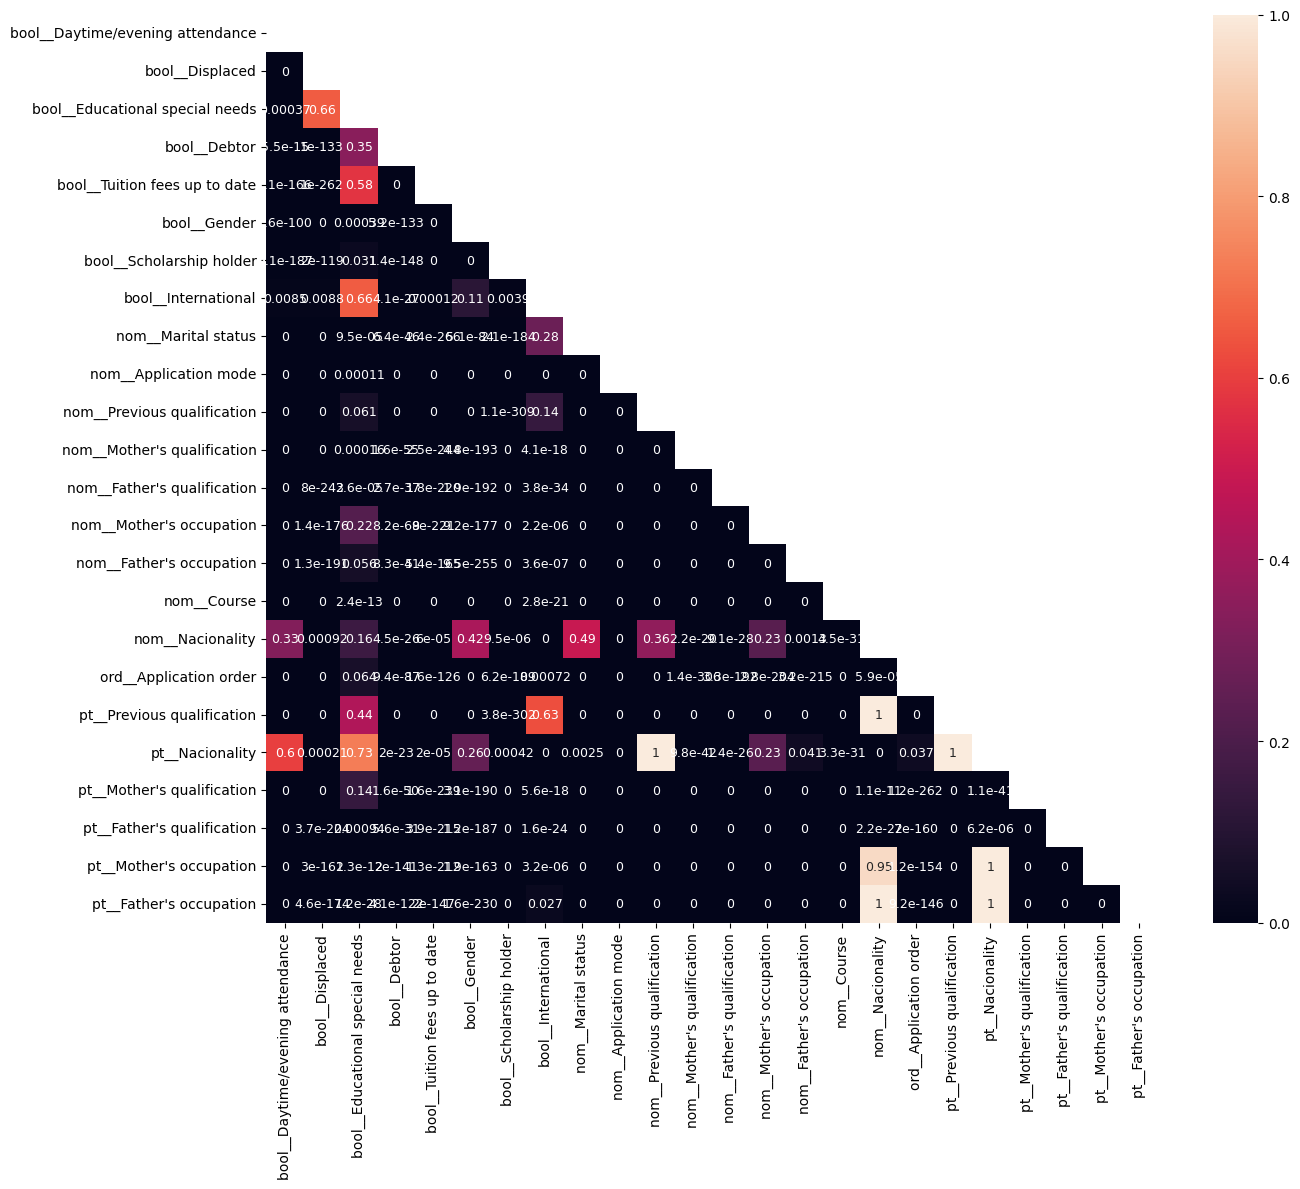

In [29]:
from scipy.spatial.distance import pdist, squareform
sc.cache_fig('heatmap_chi2_X_cat',
    lambda x: sns.heatmap(
        pd.DataFrame(squareform(
                pdist(df_cat[X_cat].T, lambda u, v: chi2_contingency(pd.crosstab(u,v)).pvalue)
        ), index=X_cat, columns=X_cat), 
        annot=True, annot_kws={'fontsize':9}, mask=np.triu(np.ones((len(X_cat), len(X_cat)))), ax=x
    ), figsize=(14, 12), redraw = 1
)

In [30]:
from sklearn.model_selection import train_test_split
df_train_sp, df_test_sp = train_test_split(df_cat, train_size=0.8, random_state=123, stratify=df_train[target])

In [31]:
vals = chi2_result.sort_values('stat', ascending=False).iloc[:5].index.tolist()
s_map = pd.crosstab(
    index=df_train_sp[vals].astype('str').sum(axis=1),
    columns=df_train_sp[target],
    normalize='index'
).idxmax(axis=1)
accuracy_score(df_test_sp[target], df_test_sp[vals].astype('str').sum(axis=1).map(s_map).fillna(df_train_sp[target].mode()[0]))

0.6817825405122844

# Continuous Variable

In [32]:
X_cont = ['Admission grade', 
'Age at enrollment', 
'Curricular units 1st sem (approved)',
'Curricular units 1st sem (credited)',
'Curricular units 1st sem (enrolled)',
'Curricular units 1st sem (evaluations)',
'Curricular units 1st sem (grade)',
'Curricular units 1st sem (without evaluations)',
'Curricular units 2nd sem (approved)',
'Curricular units 2nd sem (credited)',
'Curricular units 2nd sem (enrolled)',
'Curricular units 2nd sem (evaluations)',
'Curricular units 2nd sem (grade)',
'Curricular units 2nd sem (without evaluations)',
'GDP', 'Previous qualification (grade)', 'Unemployment rate']
len(X_cont)

17

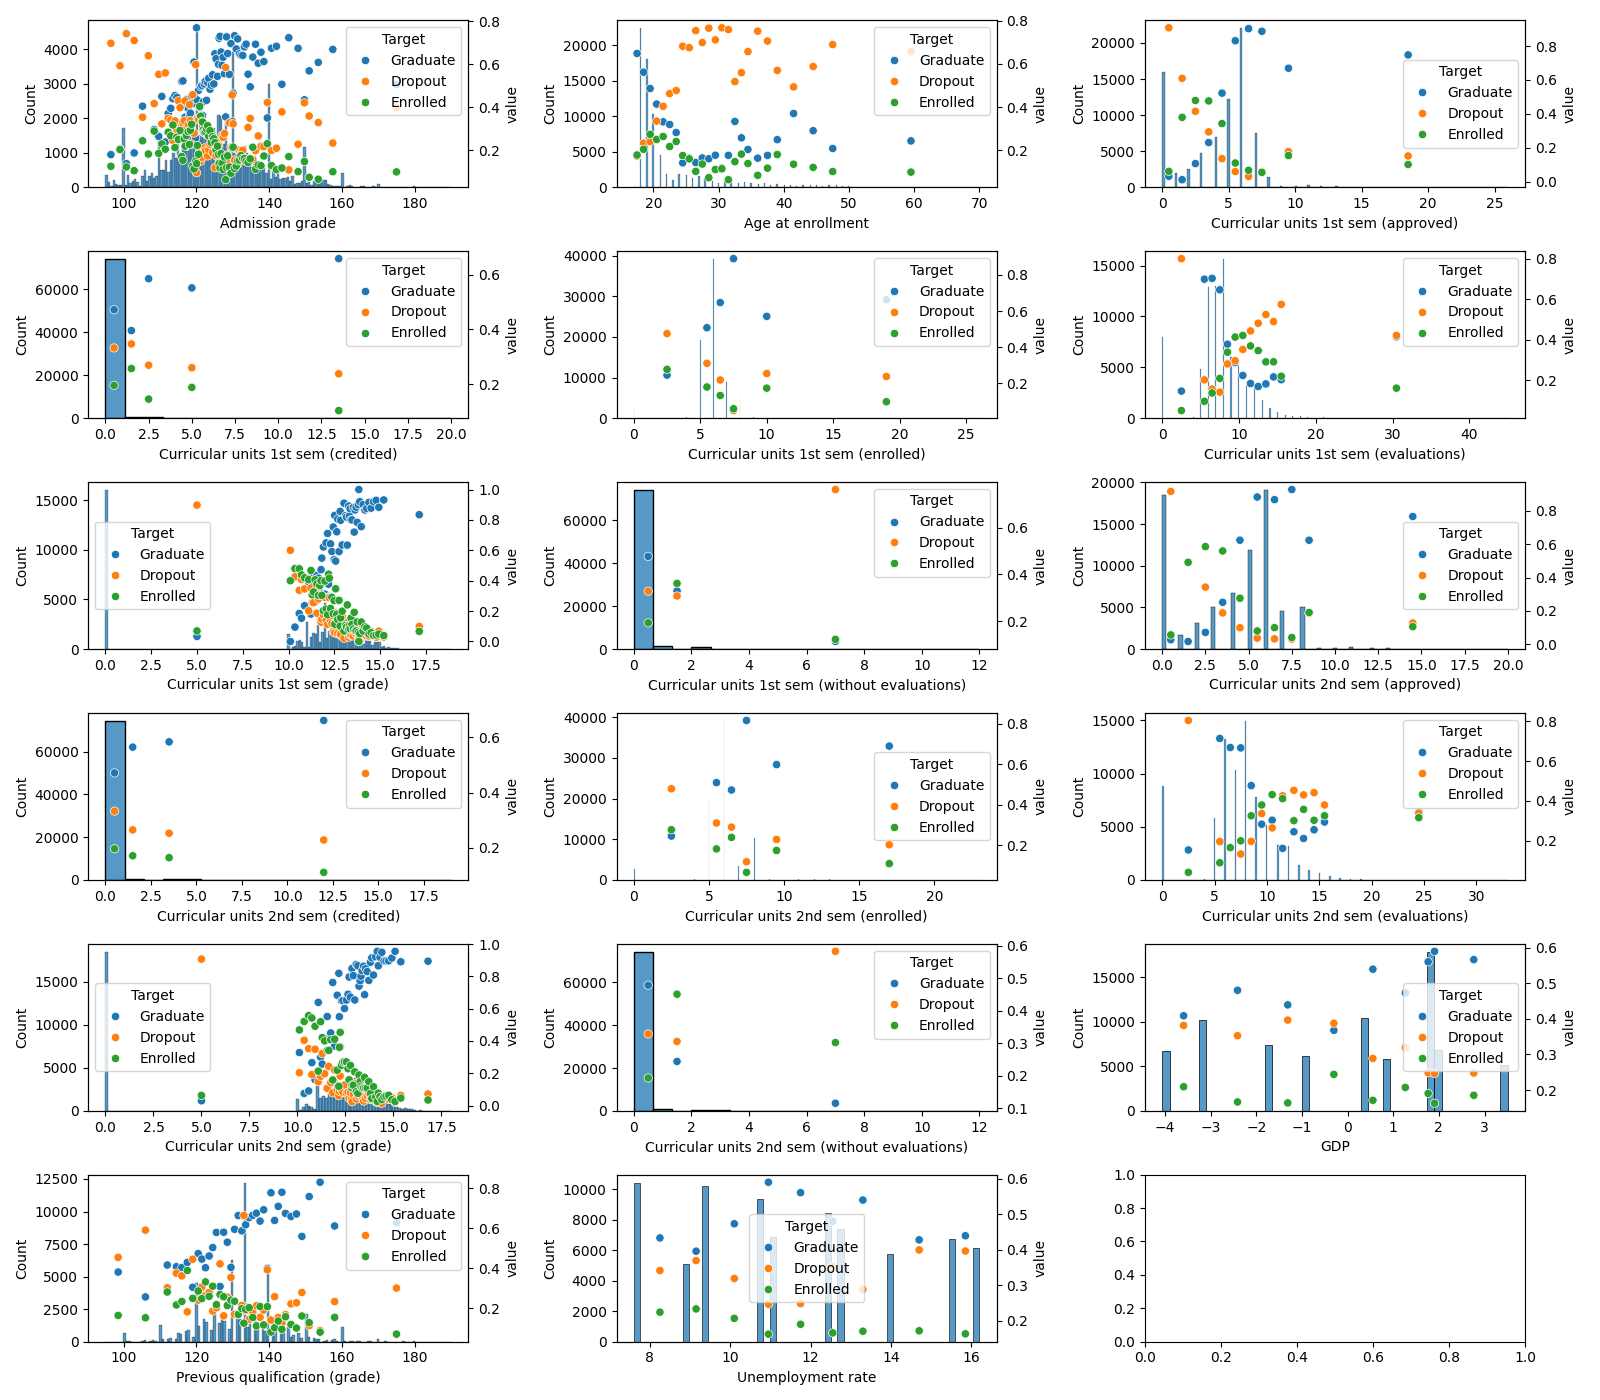

In [33]:
def plot_hist_scatter(v, ax):
    sns.histplot(df_train, x = v, ax=ax)
    pd.crosstab(
        index=pd.qcut(df_train[v], q=100, duplicates='drop'),
        columns=df_train[target], normalize='index'
    ).assign(
        **{v: lambda x: x.index.map(lambda x: (x.left + x.right) / 2)}
    ).pipe(lambda x: sns.scatterplot(x.melt(id_vars=v), x=v, y='value', hue='Target', ax=ax.twinx()))

sc.cache_fig('cont_hist_scatter',  lambda x: [plot_hist_scatter(v, ax) for v, ax in zip(X_cont, x)], 6, 3, figsize=(16, 14), redraw = 0)

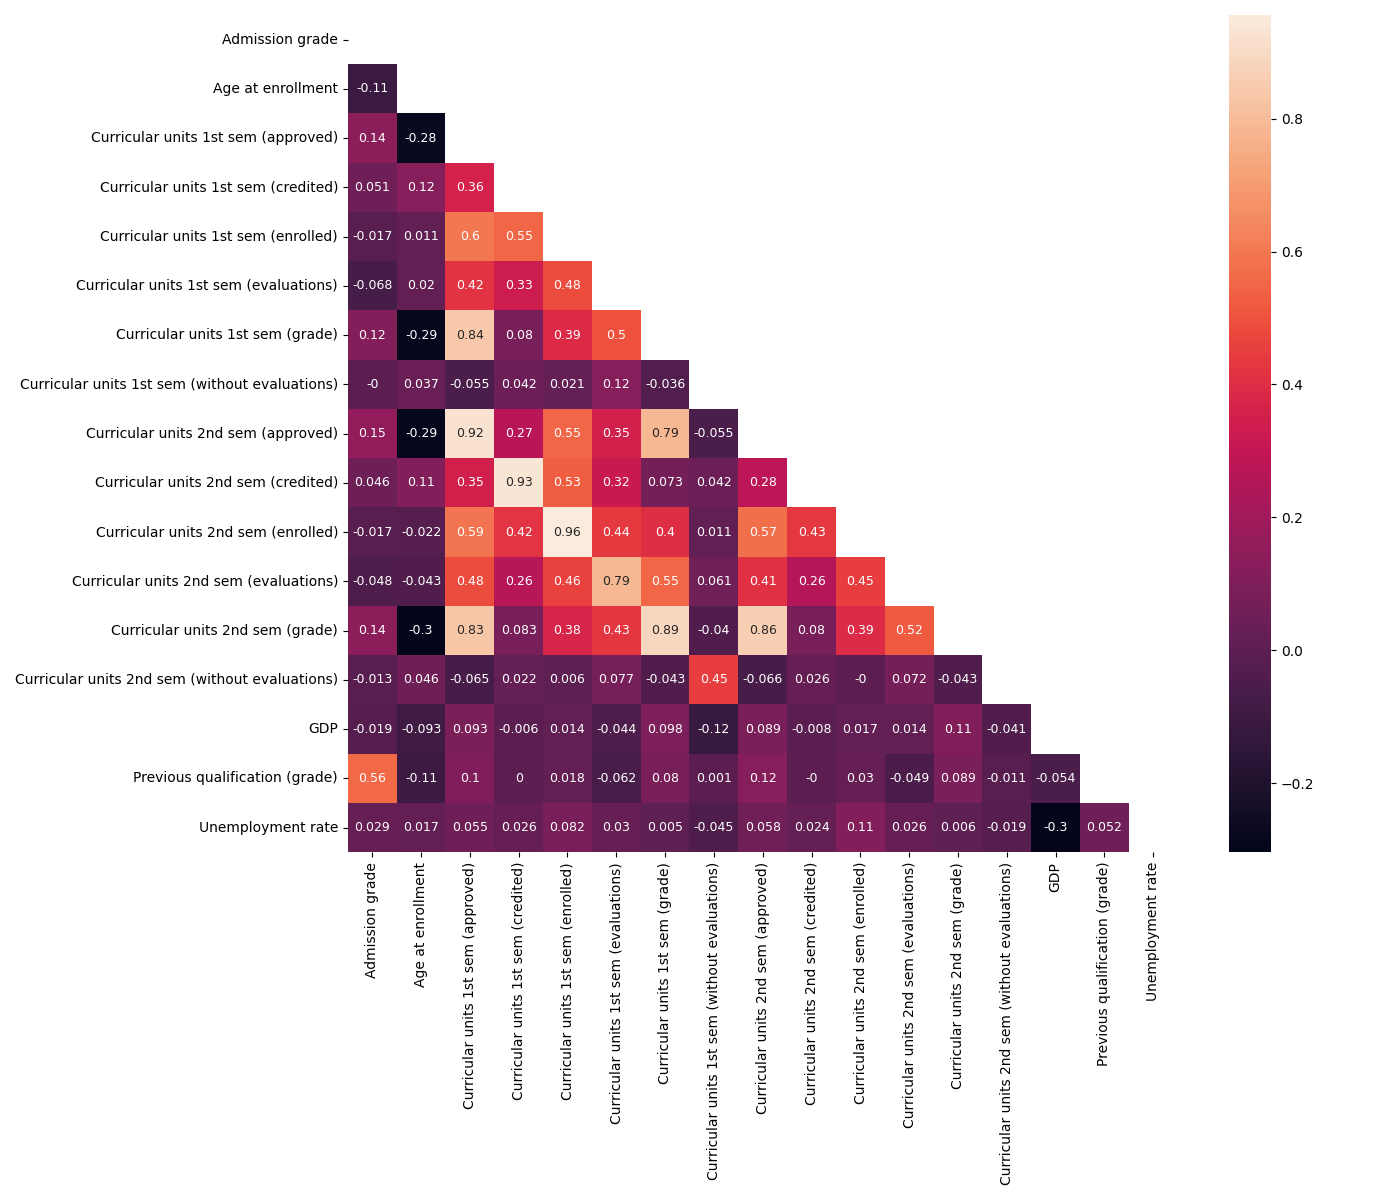

In [34]:
sc.cache_fig('heatmap_X_cont_corr',
    lambda x: sns.heatmap(
        df_train[X_cont].corr().map(lambda x: round(x, 3)),
        annot=True, annot_kws={'fontsize':9}, mask=np.triu(np.ones((len(X_cont), len(X_cont)))), ax=x
    ), figsize=(14, 12), redraw = 0
)

## Kruskal with target

In [35]:
from scipy.stats import kruskal
sc.cache_result('Kruskal',
    lambda : df_train.groupby(target, observed=True)[X_cont].agg(list).apply(
            lambda x: pd.Series(kruskal(*x), index=['statistic', 'pvalue'])
        ).T.sort_values('statistic', ascending=False)
)

,statistic,pvalue
Curricular units 2nd sem (approved),46716.267951,0.000000e+00
Curricular units 1st sem (approved),42030.077543,0.000000e+00
Curricular units 2nd sem (grade),39218.182492,0.000000e+00
Curricular units 1st sem (grade),34801.824128,0.000000e+00
Age at enrollment,10807.626415,0.000000e+00
Curricular units 2nd sem (evaluations),9388.457625,0.000000e+00
Curricular units 2nd sem (enrolled),9076.719109,0.000000e+00
Curricular units 1st sem (enrolled),8763.334639,0.000000e+00
Curricular units 1st sem (evaluations),7019.406550,0.000000e+00
Admission grade,2813.604041,0.000000e+00


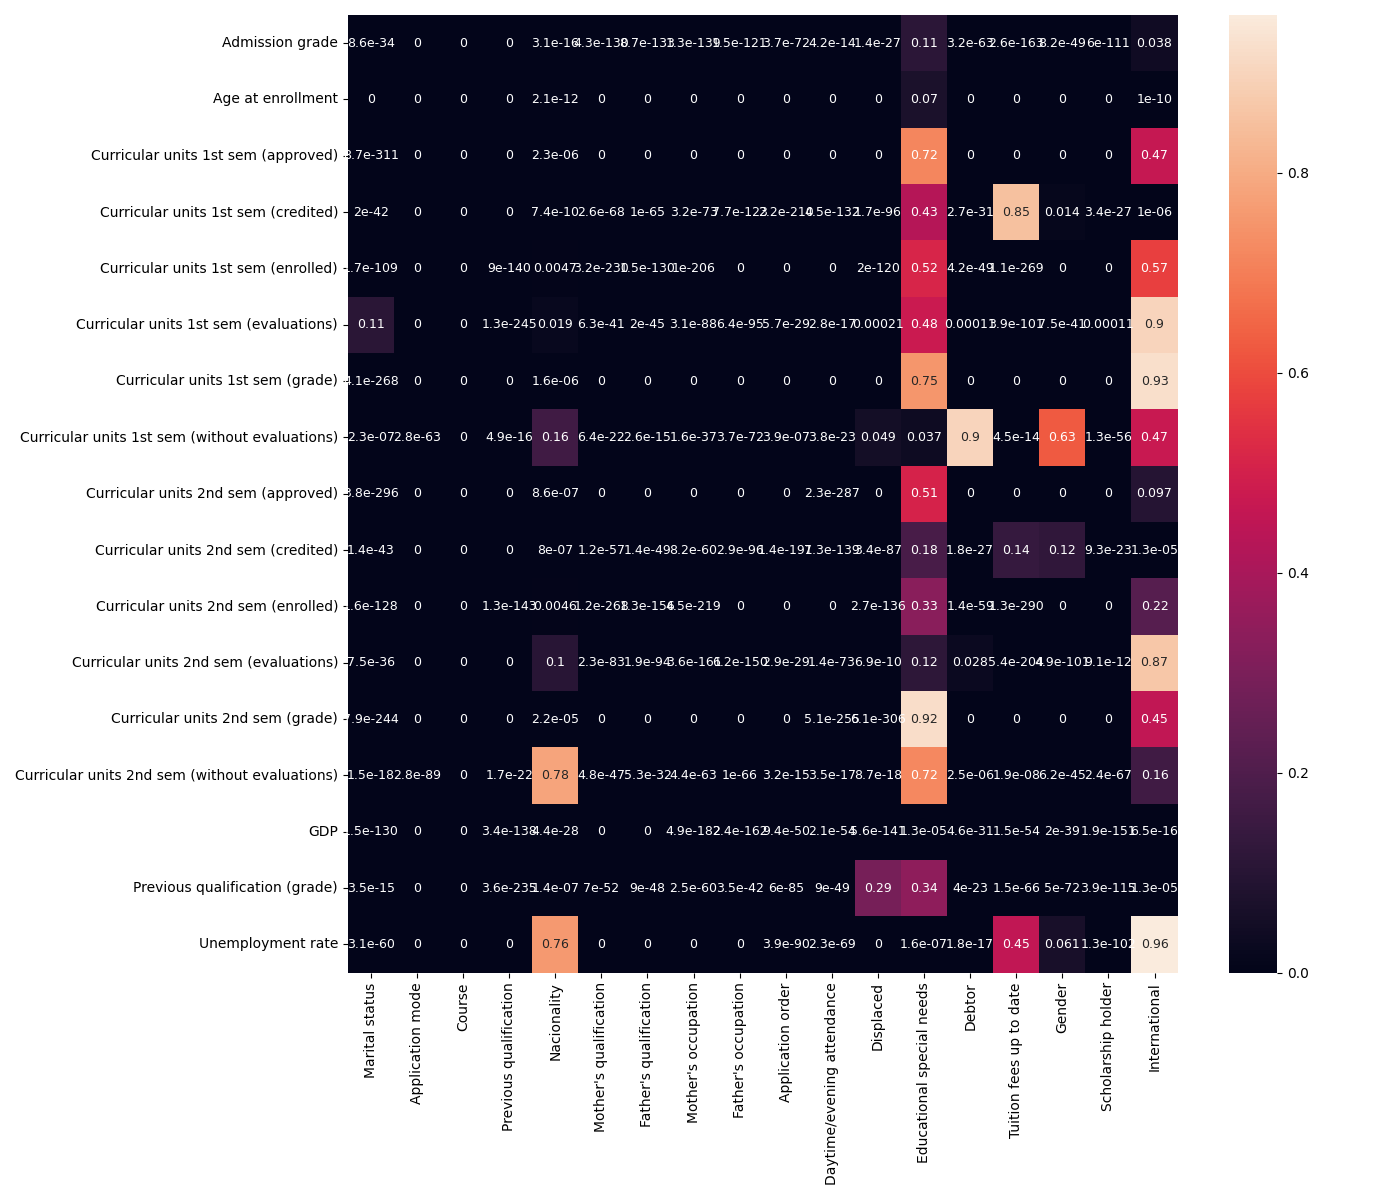

In [36]:
sc.cache_fig('heatmap_kruscal_X_bool_X_cat_R',
    lambda x: sns.heatmap(
        df_cat.apply(
            lambda x: df_train.groupby(x, observed=True)[X_cont].agg(list).apply(lambda x: kruskal(*x).pvalue, axis=0)
        ), annot=True, annot_kws={'fontsize':9}, ax=x
    ), figsize=(14, 12), redraw = 0
)

In [37]:
s_mean = df_train.groupby(target, observed=True)['Curricular units 2nd sem (approved)'].mean()
accuracy_score(
    df_train[target],
    s_mean.apply(lambda x: (x - df_train['Curricular units 2nd sem (approved)']).abs()).T.idxmin(axis=1)
)

0.7878277006717374

In [38]:
s_mean = df_train.groupby(target, observed=True)['Curricular units 1st sem (approved)'].mean()
accuracy_score(
    df_train[target],
    s_mean.apply(lambda x: (x - df_train['Curricular units 1st sem (approved)']).abs()).T.idxmin(axis=1)
)

0.7162236336548263

In [39]:
(df_train['Curricular units 2nd sem (credited)'] / df_train['Curricular units 2nd sem (approved)']).fillna(0).clip(0, 1).groupby(df_train[target], observed=True).mean()

Target
Graduate    0.019098
Dropout     0.020186
Enrolled    0.017325
dtype: float64

In [40]:
s_mean = df_train.groupby(target, observed=True)['Curricular units 2nd sem (grade)'].mean()
accuracy_score(
    df_train[target],
    s_mean.apply(lambda x: (x - df_train['Curricular units 2nd sem (grade)']).abs()).T.idxmin(axis=1)
)

0.7146030999242008

In [41]:
s_mean = df_train.groupby(target, observed=True)['Curricular units 1st sem (grade)'].mean()
accuracy_score(
    df_train[target],
    s_mean.apply(lambda x: (x - df_train['Curricular units 1st sem (grade)']).abs()).T.idxmin(axis=1)
)

0.6797093494341201

# Analysis with Machine Learning Models

In [42]:
df_ml = dproc.join_and_assign(
    df_cat,
    cbt.append('num', X_cont, df_train)
)

In [43]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import sgml, sgnn

skf = StratifiedKFold(5, shuffle=True, random_state=123)
ss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=123)
target_values = lab_enc.classes_

def get_validation_splitter(validation_frac):
    return lambda x: train_test_split(x, test_size=validation_frac, stratify=x[target], random_state=123)

config = {
    'predict_func': lambda m, df, X: pd.DataFrame(m.predict_proba(df[X]), index=df.index),
    'score_func': lambda df, prd: accuracy_score(df[target], prd.idxmax(axis=1)),
    'validation_splitter': get_validation_splitter,
    'y': target
}

lgb_adapter = sgml.LGBMAdapter(lgb.LGBMClassifier)
xgb_adapter = sgml.XGBAdapter(xgb.XGBClassifier)
cb_adapter = sgml.CBAdapter(cb.CatBoostClassifier)
nn_adapter = sgnn.NNAdapter(sgnn.NNClassifier)
lr_adapter = sgml.SklearnAdapter(LogisticRegression)

2025-01-13 21:26:34.691970: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 21:26:34.714713: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-13 21:26:35.413668: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Logistic Regression

In [44]:
result_lr = sc.cache_result(
    'lr1',
    lambda : sgml.cv(
        df_ml, skf, {
            'model_params': {'C': 1, 'max_iter': 500, 'multi_class': 'multinomial'}, 
            'X_ohe': cbt.get_vars(('cat', 'nom')) + cbt.get_vars(('cat', 'bool')) + cbt.get_vars(('cat', 'ord')), 
            'X_std': cbt.get_vars('num'), 'ohe': {'drop': 'first'}
        },  config, lr_adapter, result_proc=sgml.lr_learning_result), rerun = 0
)
np.mean(result_lr['valid_scores'])

0.8228128790930607

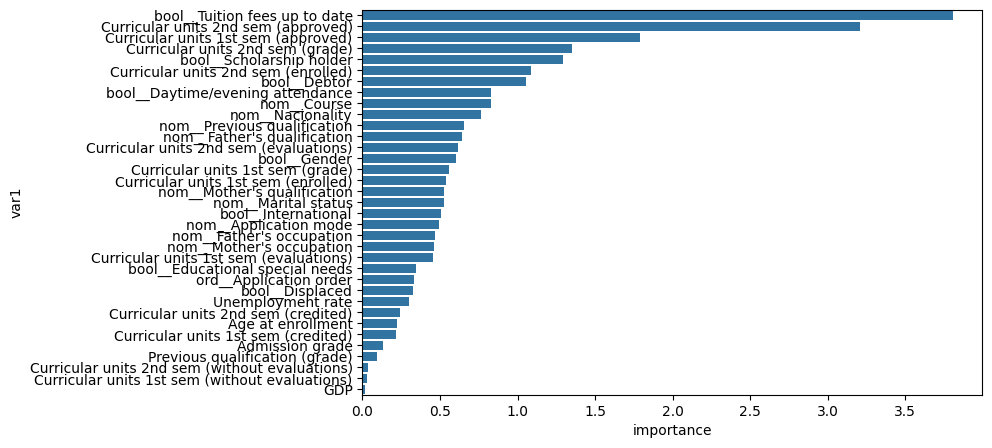

In [45]:
fig = plt.figure(figsize = (8, 5))
sns.barplot(
    pd.concat([i['coef'] for i in result_lr['model_result']], axis=0).abs().T.groupby(level=0).sum().sum().rename('importance').pipe(
        lambda x: x.to_frame().groupby(
            dproc.split_preprocessor_var(x.index.to_series(), cbt.get_vars())['var1']
        )['importance'].mean()
    ).sort_values(ascending=False).reset_index(), y = 'var1', x = 'importance'
)
plt.show()

### Numerical Processing

In [46]:
ct_num_clean = custpp.NumProcessor()
ct_num_clean.fit(df_train[X_num])
df_ml = dproc.join_and_assign(
    df_ml,
    cbt.append('np', ct_num_clean, df_train)
)

In [47]:
ct_cc = custpp.NumCombiner()
ct_cc.fit(df_train)
at = sgpp.AttachTransformer(cbt, [])
df_ml = dproc.join_and_assign(
    df_ml,
    at.append('cc', ct_cc, df_ml)
)

In [48]:
X_cont_sel = [
    'np_Age at enrollment',
    'Admission grade',
    'Previous qualification (grade)',
    'np_Curricular units 1st sem (grade)', 'np_Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (credited)', 'Curricular units 1st sem (credited)',
    'Curricular units 2nd sem (without evaluations)', 'Curricular units 1st sem (without evaluations)',
]

X_cat_sel = cbt.get_vars(('cat', 'nom')) + cbt.get_vars(('cat', 'bool')) + cbt.get_vars(('cat', 'ord')) + [
    'np_Curricular units 2nd sem (approved)', 'np_Curricular units 1st sem (approved)',
    'np_Curricular units 2nd sem (enrolled)', 'np_Curricular units 1st sem (enrolled)',
    'np_Curricular units 2nd sem (evaluations)', 'np_Curricular units 1st sem (evaluations)'
]
X_num_sel = []
result = sc.cache_result(
    'lr3',
    lambda : sgml.cv(df_ml, skf, {'model_params': {'C': 1, 'max_iter': 500, 'multi_class': 'multinomial'}, 
            'X_tgt': ['1st_eval_grade', '2nd_eval_grade'], 'tgt': {'random_state': 123 },
            'X_ohe': X_cat_sel, 'X_mm': X_cont_sel, 'X_num': X_num_sel, 'ohe': {'drop': 'first', 'handle_unknown': 'ignore'}}, config, lr_adapter, 
                     result_proc=sgml.lr_learning_result), rerun = 0
)
np.mean(result['valid_scores']), np.mean(result['train_scores'])

(0.8280666014361442, 0.8299321733342436)

In [49]:
pd.concat([i['coef'] for i in result['model_result']], axis=0).abs().T.groupby(level=0).sum().sum()\
    .rename('importance').pipe(
        lambda x: x.to_frame().groupby(
            dproc.split_preprocessor_var(x.index.to_series(), at.get_vars())['var1']
        )['importance'].mean()
    ).sort_values(ascending=False)

var1
np_Curricular units 2nd sem (grade)               5.182652
bool__Tuition fees up to date                     3.661397
Curricular units 2nd sem (credited)               3.363622
Curricular units 1st sem (credited)               3.067447
np_Curricular units 1st sem (grade)               2.740672
np_Curricular units 2nd sem (approved)            2.736760
np_Curricular units 1st sem (approved)            1.705232
np_Curricular units 2nd sem (evaluations)         1.584202
np_Age at enrollment                              1.442115
np_Curricular units 2nd sem (enrolled)            1.297167
bool__Scholarship holder                          1.284111
np_Curricular units 1st sem (evaluations)         1.220394
np_Curricular units 1st sem (enrolled)            1.208080
2nd_eval_grade                                    1.165378
bool__Debtor                                      1.037566
Curricular units 1st sem (without evaluations)    0.960989
nom__Nacionality                                  0

In [50]:
X_cont_sel = [
    'np_Age at enrollment',
    'Admission grade', 
    'Previous qualification (grade)'
]

X_cat_sel = [
    'nom__Course',
    'bool__Tuition fees up to date',
    'nom__Previous qualification',
    'np_Curricular units 2nd sem (approved)', 'np_Curricular units 1st sem (approved)',
    'np_Curricular units 2nd sem (enrolled)', 'np_Curricular units 1st sem (enrolled)',
    'np_Curricular units 2nd sem (evaluations)', 'np_Curricular units 1st sem (evaluations)'
]

result = sc.cache_result(
    'lr_small',
    lambda : sgml.cv(df_ml, skf, {'model_params': {'C': 1, 'max_iter': 500, 'multi_class': 'multinomial'}, 
            'X_ohe': X_cat_sel, 'X_mm': X_cont_sel, 'ohe': {'drop': 'first'}}, config, lr_adapter, result_proc=sgml.lr_learning_result), rerun = 0
)
np.mean(result['valid_scores'])

0.8199638866597125

In [51]:
pd.concat([i['coef'] for i in result['model_result']], axis=0).abs().T.groupby(level=0).sum().sum()\
    .rename('importance').pipe(
        lambda x: x.to_frame().groupby(
            dproc.split_preprocessor_var(x.index.to_series(), at.get_vars())['var1']
        )['importance'].mean()
    ).sort_values(ascending=False)

var1
np_Curricular units 2nd sem (approved)       5.122449
bool__Tuition fees up to date                4.120624
np_Curricular units 1st sem (approved)       2.840937
np_Age at enrollment                         1.571623
np_Curricular units 2nd sem (evaluations)    1.463064
np_Curricular units 1st sem (enrolled)       1.361755
np_Curricular units 2nd sem (enrolled)       1.348787
Admission grade                              1.187855
np_Curricular units 1st sem (evaluations)    1.098442
Previous qualification (grade)               0.835353
nom__Course                                  0.782432
nom__Previous qualification                  0.651721
Name: importance, dtype: float64

## LGB

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

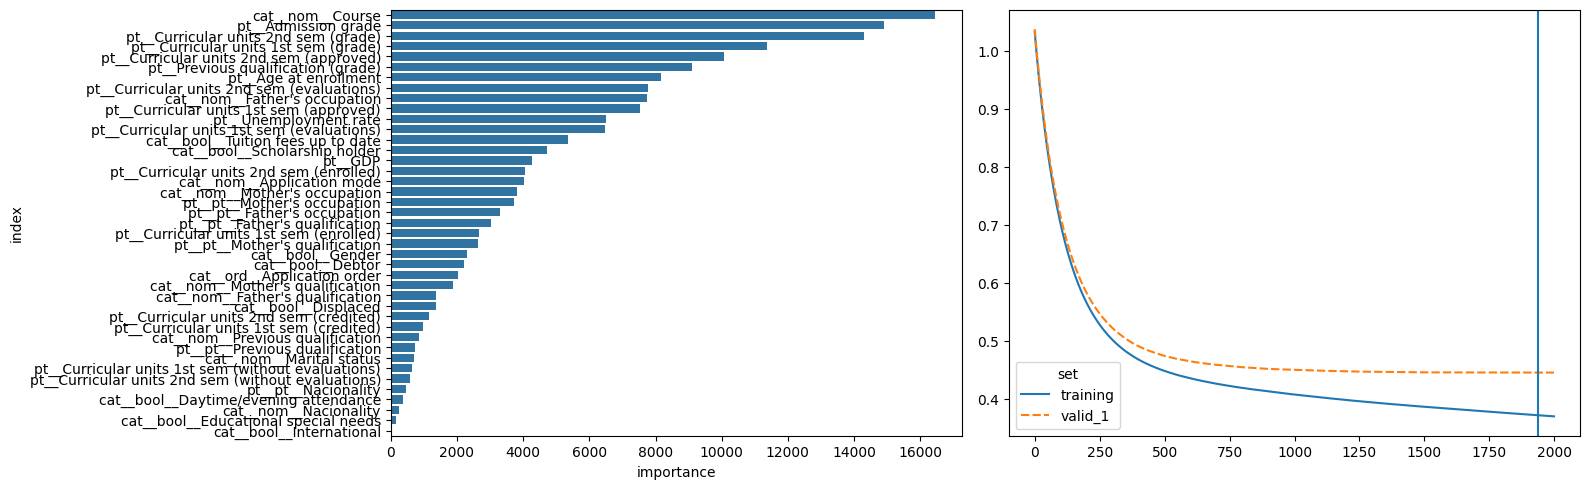

[0.8303711447987454] [0.8533832129904924]


In [52]:
result_lgb = sc.cache_result(
    'lgb_pilot',
    lambda : sgml.cv(df_ml, ss, {
        'model_params': {'n_estimators': 2000, 'learning_rate': 0.005}, 
        'validation_fraction': 0.1,
        'X_num': at.get_vars('num') + cbt.get_vars(('cat', 'pt')), 
        'X_cat': cbt.get_vars(('cat', 'nom')) + cbt.get_vars(('cat', 'bool')) + cbt.get_vars(('cat', 'ord'))
    }, config, lgb_adapter), rerun=0
)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
df_loss = result_lgb['model_result'][0]['valid_result'].stack(level=0, future_stack=True).reset_index(level=-1, drop=True)
sns.barplot(
    result_lgb['model_result'][0]['feature_importance'].sort_values(ascending=False).rename('importance').reset_index(), y='index', x='importance', ax=axes[0]
)
sns.lineplot(df_loss, ax=axes[1])
axes[1].axvline(df_loss['valid_1'].idxmin())
plt.tight_layout()
plt.show()
print(result_lgb['valid_scores'], result_lgb['train_scores'])

In [53]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(
    confusion_matrix(
        df_ml.loc[result['valid_prd'].index, target], result['valid_prd'].idxmax(axis=1)
    ), index = target_values, columns = target_values
)

,Dropout,Enrolled,Graduate
Dropout,20853,2763,1680
Enrolled,1822,8587,4531
Graduate,733,2247,33302


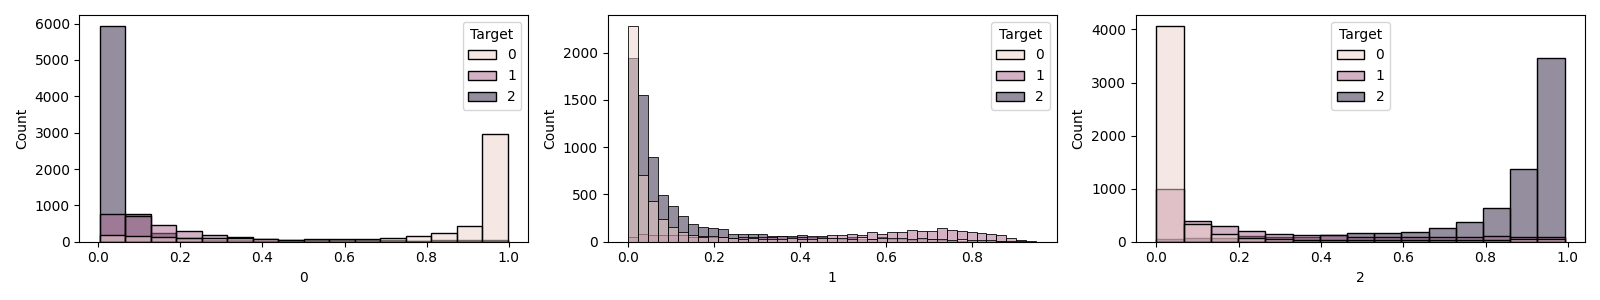

In [54]:
sc.cache_fig(
    'predict_prob_dist',
    lambda axes: result_lgb['valid_prd'].join(df_ml[target], how = 'inner').pipe(
        lambda x: [sns.histplot(x, x = i, hue=target, ax=ax) for i, ax in enumerate(axes)]
    ), 1, 3, figsize = (16, 3), redraw = 0
)

## XGB

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

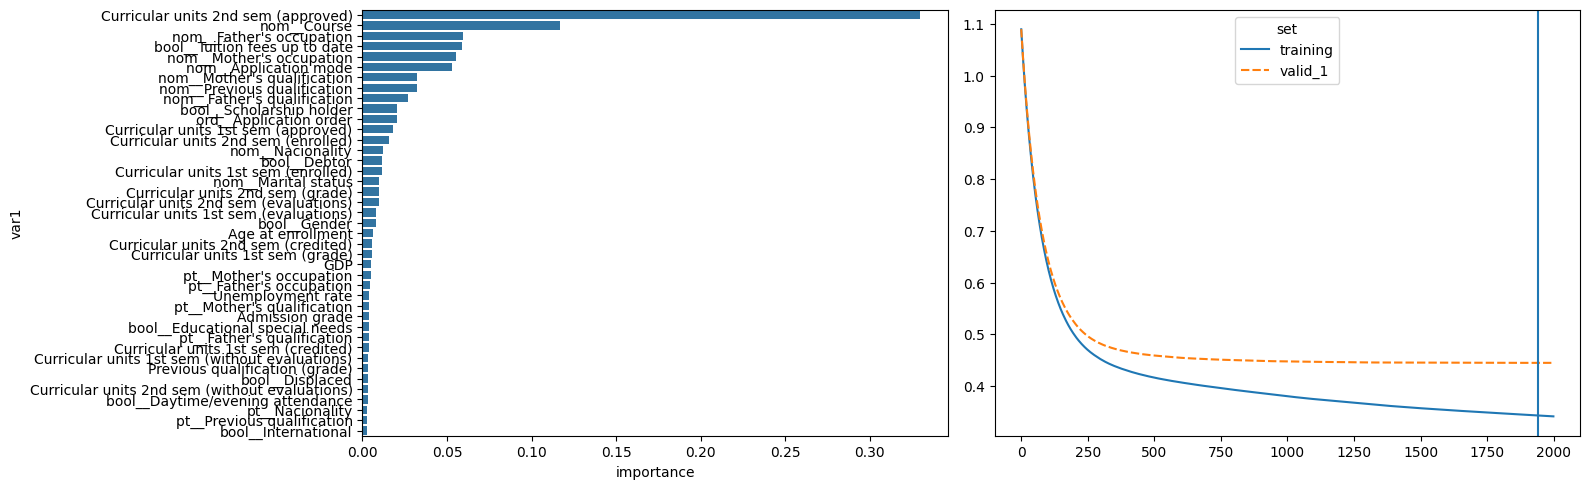

[0.8299137480397282] [0.8675303035253373]


In [55]:
result_xgb = sc.cache_result(
    'xgb_pilot',
    lambda : sgml.cv(df_ml, ss, {
        'model_params': {'n_estimators': 2000, 'learning_rate': 0.01}, 
        'validation_fraction': 0.1,
        'X_num': at.get_vars('num') +  cbt.get_vars(('cat', 'pt')), 
        'X_cat': cbt.get_vars(('cat', 'nom')) + cbt.get_vars(('cat', 'bool')) + cbt.get_vars(('cat', 'ord'))
    }, config, xgb_adapter), rerun = 0
)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
df_loss = result_xgb['model_result'][0]['valid_result'].stack(
    level=0, future_stack=True
).reset_index(level=-1, drop=True).rename(columns={'validation_0': 'training', 'validation_1': 'valid_1'})

s_index = result_xgb['model_result'][0]['feature_importance'].index.to_series()
df_imp = result_xgb['model_result'][0]['feature_importance'].rename('importance').to_frame().groupby(
    dproc.split_preprocessor_var(s_index, at.get_vars())['var1']
).sum().sort_values('importance', ascending=False)
sns.barplot(df_imp, x='importance', y='var1', ax=axes[0])
sns.lineplot(df_loss, ax=axes[1])
axes[1].axvline(df_loss['valid_1'].idxmin())
plt.tight_layout()
plt.show()
print(result_xgb['valid_scores'], result_xgb['train_scores'])

## CB

In [63]:
result_cb1 = sc.cache_result(
    'cb_pilot',
    lambda : sgml.cv(df_ml, ss, {
        'model_params': {'n_estimators': 2000, 'learning_rate': 0.04, 'random_state': 123}, 
        'validation_fraction': 0.1,
        'X_num':  at.get_vars('num') +  cbt.get_vars(('cat', 'pt')),  
        'X_cat':  cbt.get_vars(('cat', 'nom')) + cbt.get_vars(('cat', 'bool')) + cbt.get_vars(('cat', 'ord'))
    }, config, cb_adapter, result_proc=[
        sgml.cb_learning_result, sgml.cb_interaction_importance, partial(sgml.gb_shap_learning_result, df=df_ml.sample(frac=0.1))
    ]), rerun = 0
)
result_cb1['valid_scores'], result_cb1['train_scores']

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

([0.8335729221118662], [0.8499199529519391])

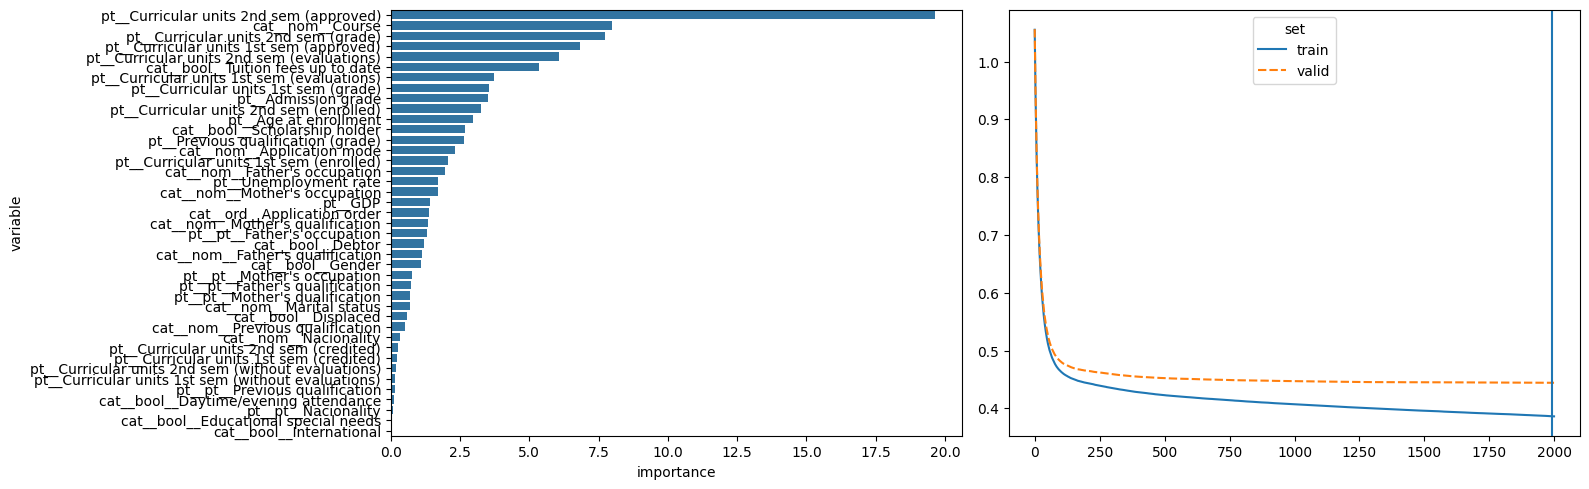

In [64]:
fig, axes = plt.subplots(1, 2, figsize = (16, 5))
sns.barplot(
    result_cb1['model_result'][0]['feature_importance'].sort_values(ascending = False).reset_index().rename(
        columns = {'index': 'variable', 0: 'importance'}
    ), x = 'importance', y = 'variable', ax = axes[0]
)
df_loss = result_cb1['model_result'][0]['valid_result'].T.reset_index(0, drop=True).drop(index = 'learn').rename(
    index = {'validation_0': 'train', 'validation_1': 'valid'}
).T
sns.lineplot(df_loss, ax = axes[1])
axes[1].axvline(df_loss['valid'].idxmin())
plt.tight_layout()
plt.show()

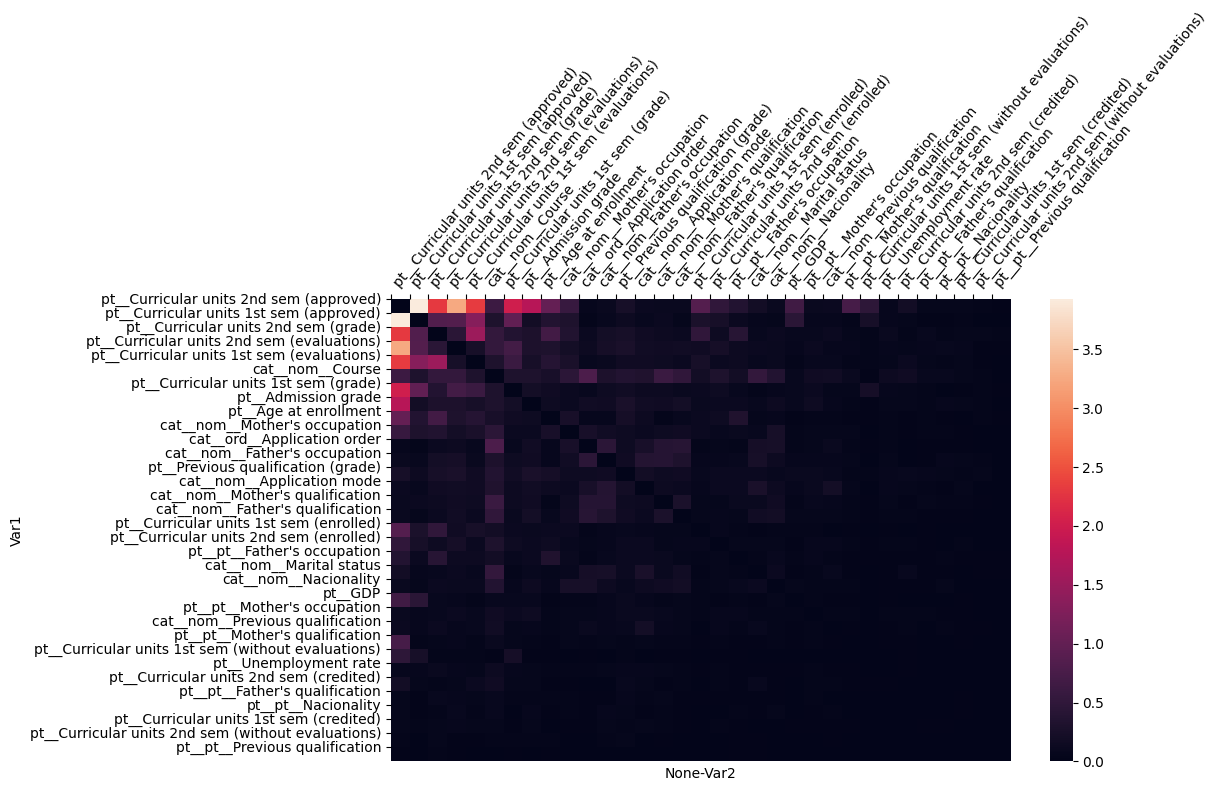

In [65]:
df_cb_inter = pd.concat([
    result_cb1['model_result'][1],
    result_cb1['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
sns.heatmap(df_cb_inter)
plt.yticks(
    range(df_cb_inter.shape[0]), df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0, horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]), df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4, horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

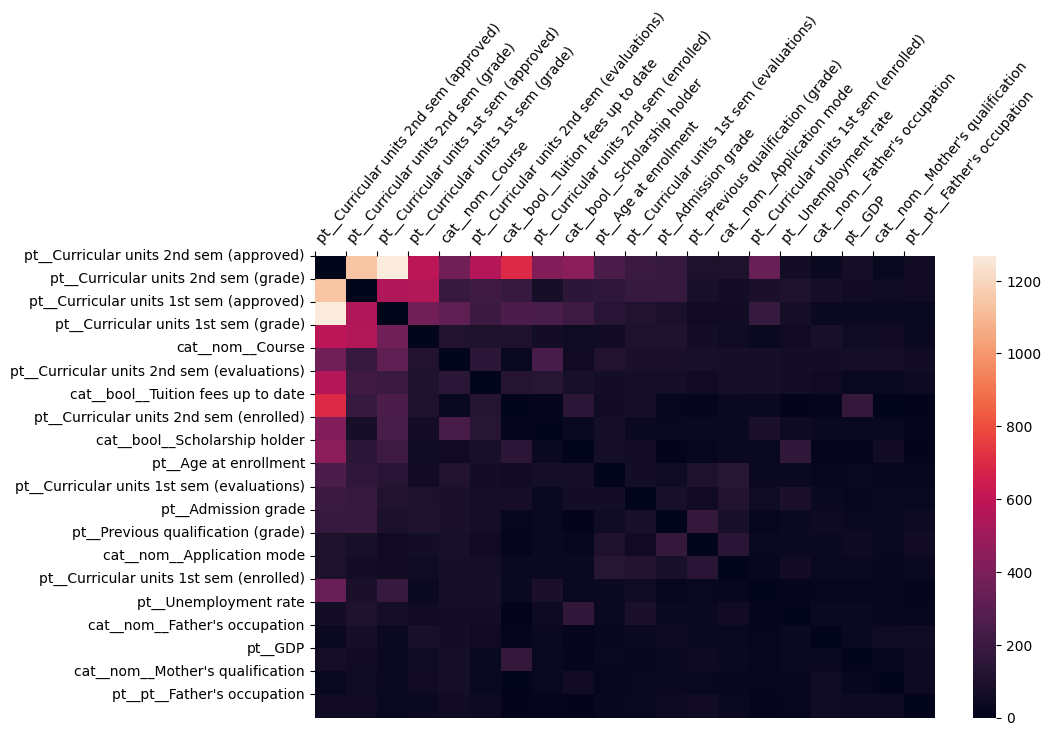

In [66]:
interaction_matrix = np.abs(result_cb1['model_result'][2]['shap_interaction_values']).sum(0).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:20]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(10, 6))
sns.heatmap(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    result_cb1['model_result'][0]['variables'][inds],
    rotation=0, horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    result_cb1['model_result'][0]['variables'][inds],
    rotation=50.4, horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

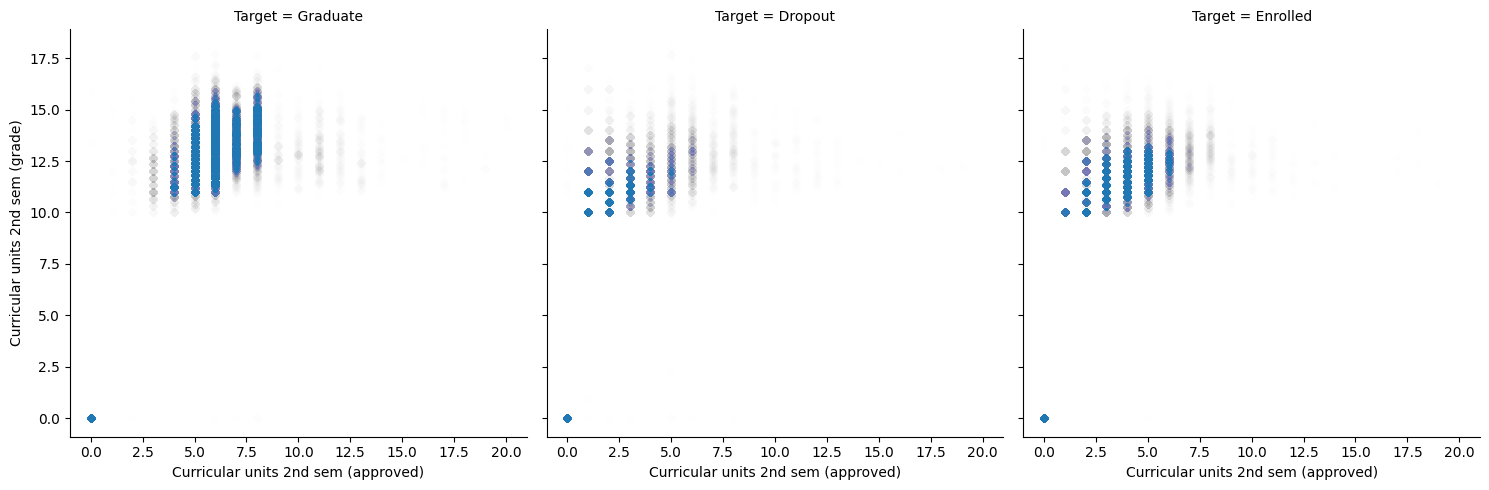

In [67]:
sns.relplot(
    df_train, x = 'Curricular units 2nd sem (approved)', y = 'Curricular units 2nd sem (grade)', col=target, kind='scatter', alpha = 0.005
)
plt.show()

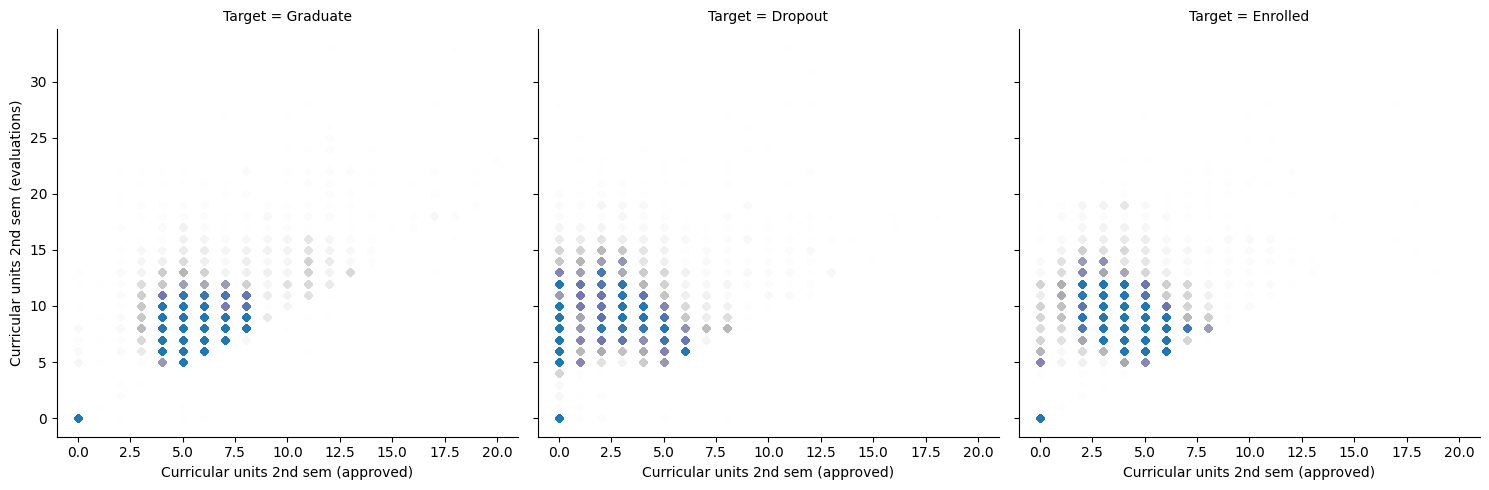

In [68]:
sns.relplot(
    df_train, x = 'Curricular units 2nd sem (approved)', y = 'Curricular units 2nd sem (evaluations)', col=target, kind='scatter', alpha = 0.005
)
plt.show()

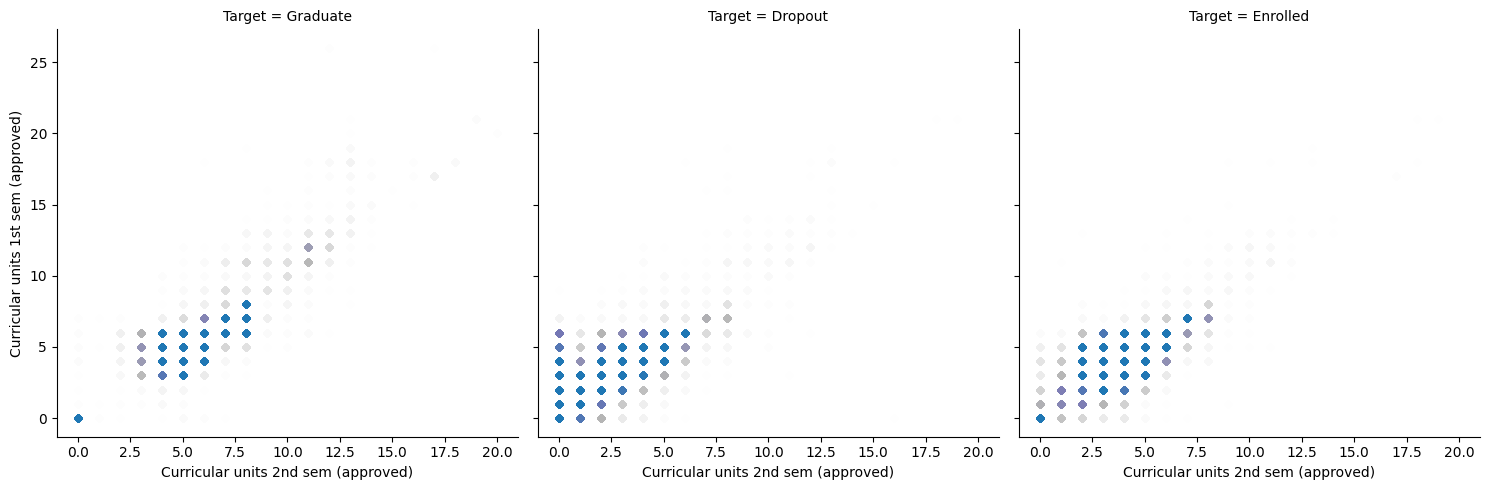

In [69]:
sns.relplot(
    df_train, x = 'Curricular units 2nd sem (approved)', y = 'Curricular units 1st sem (approved)', col=target, kind='scatter', alpha = 0.005
)
plt.show()

In [70]:
result_cb2 = sc.cache_result(
    'cb_pilot_clip',
    lambda : sgml.cv(df_ml, ss, {
        'model_params': {'n_estimators': 2000, 'learning_rate': 0.04, 'random_state': 123}, 
        'validation_fraction': 0.1,
        'X_num': at.get_vars('np') + ['Previous qualification (grade)', 'Admission grade', 'Unemployment rate', 'GDP'] + cbt.get_vars(('cat', 'pt')), 
        'X_cat': cbt.get_vars(('cat', 'nom')) + cbt.get_vars(('cat', 'bool')) + cbt.get_vars(('cat', 'ord')),
    }, config, cb_adapter, result_proc=[sgml.cb_learning_result, sgml.cb_interaction_importance]), rerun=0
)
result_cb2['valid_scores'], result_cb2['train_scores']

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

([0.8314819654992159], [0.8490214656777861])

In [71]:
result_cb3 = sc.cache_result(
    'cb_pilot_num_cat',
    lambda : sgml.cv(df_ml, ss, {
        'model_params': {'n_estimators': 2000, 'learning_rate': 0.04, 'random_state': 123}, 
        'validation_fraction': 0.1,
        'X_num': at.get_vars('num') + cbt.get_vars(('cat', 'pt')), 
        'X_cat': cbt.get_vars(('cat', 'nom')) + cbt.get_vars(('cat', 'bool')) + cbt.get_vars(('cat', 'ord')) + [i for i in at.get_vars('np') if (i.find('grade') == -1) & (i.find('Age') == -1)] + at.get_vars('cc'), 
    }, config, cb_adapter, result_proc=[sgml.cb_learning_result, sgml.cb_interaction_importance]), rerun = 0
)
result_cb3['valid_scores'], result_cb3['train_scores']

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

([0.8323314166231051], [0.8460646257392099])

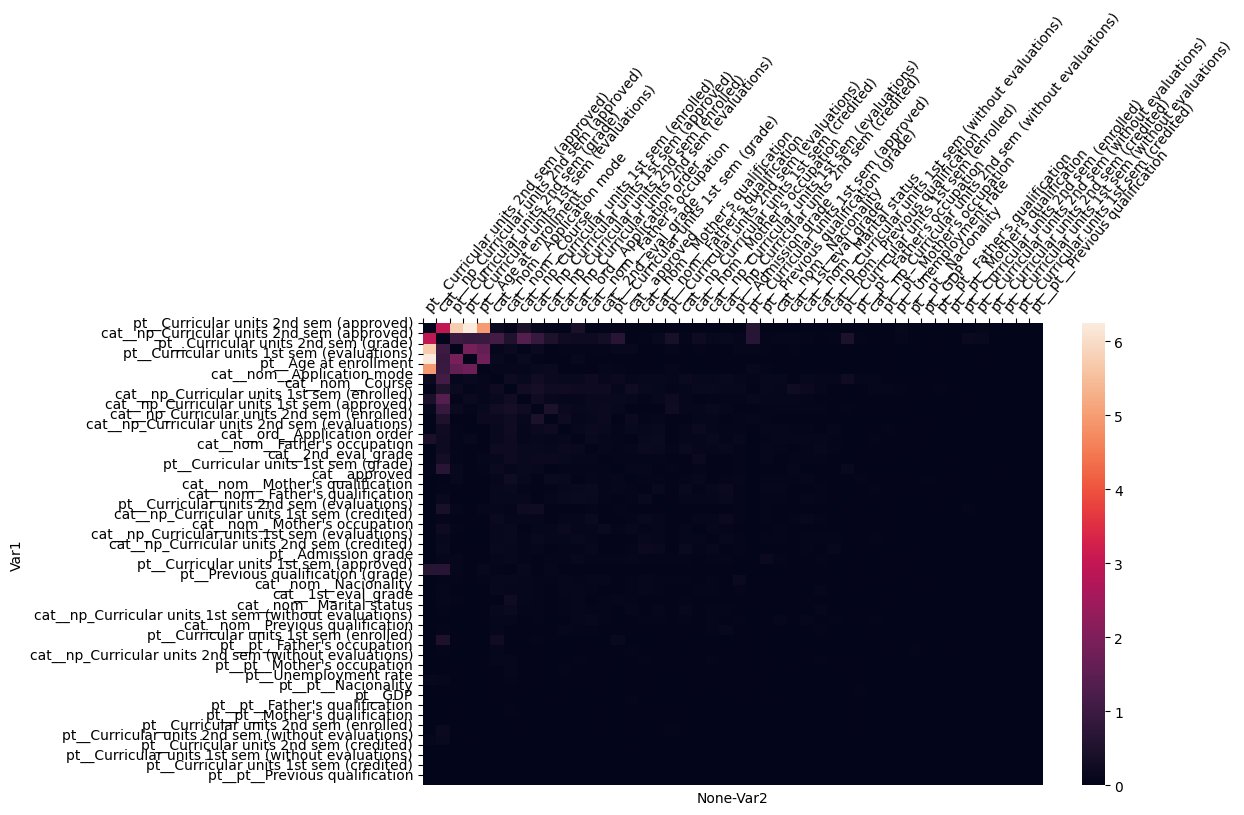

In [72]:
df_cb_inter = pd.concat([
    result_cb3['model_result'][1],
    result_cb3['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
sns.heatmap(df_cb_inter)
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0, horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4, horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

In [73]:
ct_eval = sgpp.EvalTransformer([
    ('with_eval_1st', '`np_Curricular units 1st sem (enrolled)` - `np_Curricular units 1st sem (without evaluations)`'),
    ('with_eval_2nd', '`np_Curricular units 2nd sem (enrolled)` - `np_Curricular units 2nd sem (without evaluations)`'),
    ('not_approved_1st', '`np_Curricular units 1st sem (enrolled)` - `np_Curricular units 1st sem (approved)`'),
    ('not_approved_2nd', '`np_Curricular units 2nd sem (enrolled)` - `np_Curricular units 2nd sem (approved)`'),
])

In [74]:
result_cb4 = sc.cache_result(
    'cb_pilot_grade_with_eval',
    lambda : sgml.cv(dproc.join_and_assign(df_ml, ct_eval.transform(df_ml)), ss, {
        'model_params': {'n_estimators': 2000, 'learning_rate': 0.04, 'random_state': 123}, 
        'validation_fraction': 0.1,
        'X_num': at.get_vars('num') + ['with_eval_1st', 'with_eval_2nd'] + cbt.get_vars(('cat', 'pt')), 
        'X_cat': cbt.get_vars(('cat', 'nom')) + cbt.get_vars(('cat', 'bool')) + cbt.get_vars(('cat', 'ord')), 
    }, config, cb_adapter, result_proc=[sgml.cb_learning_result, sgml.cb_interaction_importance]), rerun = 0
)
result_cb4['valid_scores'], result_cb4['train_scores']

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

([0.8325927861996864], [0.8486293985036103])

In [75]:
result_cb5 = sc.cache_result(
    'cb_pilot_grade_not_approved',
    lambda : sgml.cv(dproc.join_and_assign(df_ml, ct_eval.transform(df_ml)), ss, {
        'model_params': {'n_estimators': 2000, 'learning_rate': 0.04, 'random_state': 123}, 
        'validation_fraction': 0.1,
        'X_num': at.get_vars('num') + ['not_approved_1st', 'not_approved_2nd'] + cbt.get_vars(('cat', 'pt')),
        'X_cat': cbt.get_vars(('cat', 'nom')) + cbt.get_vars(('cat', 'bool')) + cbt.get_vars(('cat', 'ord')), 
    }, config, cb_adapter, result_proc=[sgml.cb_learning_result, sgml.cb_interaction_importance]), rerun = 0
)
result_cb5['valid_scores'], result_cb5['train_scores']

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

([0.8330501829587036], [0.8494952135132486])

In [76]:
result_cb5['model_result'][0]['feature_importance'].sort_values(ascending = False).iloc[:20]

pt__Curricular units 2nd sem (approved)       13.215326
pt__Curricular units 2nd sem (grade)           7.814096
pt__not_approved_2nd                           7.810041
cat__nom__Course                               7.702509
pt__Curricular units 2nd sem (evaluations)     5.693022
cat__bool__Tuition fees up to date             5.517685
pt__not_approved_1st                           5.088177
pt__Admission grade                            3.597349
pt__Curricular units 1st sem (grade)           3.596448
pt__Curricular units 1st sem (evaluations)     3.202027
pt__Curricular units 1st sem (approved)        3.128024
pt__Previous qualification (grade)             2.800700
cat__nom__Application mode                     2.681089
pt__Age at enrollment                          2.640737
cat__bool__Scholarship holder                  2.575695
cat__nom__Father's occupation                  2.063951
pt__Curricular units 2nd sem (enrolled)        1.686362
pt__Unemployment rate                          1

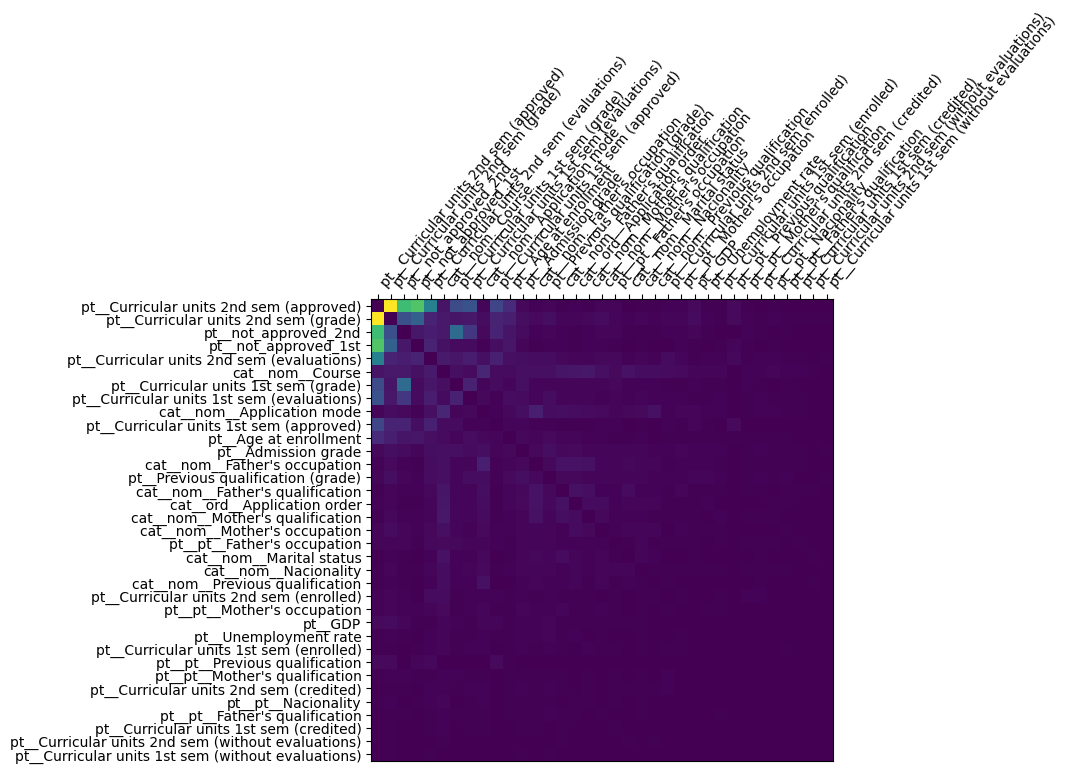

In [77]:
df_cb_inter = pd.concat([
    result_cb5['model_result'][1],
    result_cb5['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
plt.imshow(df_cb_inter)
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

In [78]:
result_cb6 = sc.cache_result(
    'cb_pilot_grade_not_approved_pca',
    lambda : sgml.cv(df_ml, ss, {
        'model_params': {'n_estimators': 2000, 'learning_rate': 0.04, 'random_state': 123}, 
        'validation_fraction': 0.1,
        'X_num': at.get_vars('num') ,
        'X_cat': at.get_vars('cat'), 
        'pca': {
            'X_std': at.get_vars('np'),
            'n_components': 1
        }
    }, config, cb_adapter, result_proc=[sgml.cb_learning_result, sgml.cb_interaction_importance])
)
result_cb6['valid_scores'], result_cb6['train_scores']

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

([0.8323967590172504], [0.8533832129904924])

## NN

In [79]:
emb_config = [
    ('nom__Course', 3),
    ('nom__Application mode', 2),
    ('nom__Previous qualification', 2),
    ("nom__Mother's qualification", 2),
    ("nom__Father's qualification", 2),
    ("nom__Mother's occupation", 2),
    ("nom__Father's occupation", 2),
    ('nom__Marital status', 2),
]
embedding = [(1, len(df_ml[a].cat.categories), b, 0, 0) for a, b in emb_config]
result_nn1 = sc.cache_result(
    'nn_pilot',
    lambda : sgml.cv(df_ml, ss, {
        'model_params': {
            'model_params': {
                'config': [
                    {'unit': 128, 'activation': 'relu', 'batch_norm': True},
                    {'unit': 128, 'activation': 'relu', 'batch_norm': True},
                    {'unit': 64, 'activation': 'relu', 'batch_norm': True},
                    {'unit': 32, 'activation': 'relu', 'batch_norm': True},
                ], 'embedding': embedding,
            },
            'batch_size': 1024,
            'shuffle_size': 204800, 'epochs': 50, 'optimizer': ('Adam', {'learning_rate': 0.0002})
        }, 
        'validation_fraction': 0.1,
        'X_std': at.get_vars('np'),
        'X_mm': ['ord__Application order'],
        'X_num': at.get_vars(('cat', 'bool')),
        'X_cat': [i for i,_ in emb_config],
    }, config, nn_adapter)
)
result_nn1['valid_scores'], result_nn1['train_scores']

2025-01-13 18:11:44.510806: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-13 18:11:44.621674: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Step:   0%|          | 0/54 [00:00<?, ?it/s]

([0.8193936225823314], [0.8448394158199105])

In [80]:
emb_config = [
    ('nom__Course', 3),
    ('nom__Application mode', 2),
    ('nom__Previous qualification', 2),
    ("nom__Mother's qualification", 2),
    ("nom__Father's qualification", 2),
    ("nom__Mother's occupation", 2),
    ("nom__Father's occupation", 2),
    ('nom__Marital status', 2),
]
embedding = [(1, len(df_ml[a].cat.categories), b, 0, 0) for a, b in emb_config]
result_nn2 = sc.cache_result(
    'nn_pilot2',
    lambda : sgml.cv(df_ml, ss, {
        'model_params': {
            'model_params': {
                'config': [
                    {'unit': 32, 'activation': 'relu', 'batch_norm': True},
                ], 'embedding': embedding,
            },
            'batch_size': 1024,
            'shuffle_size': 204800, 'epochs': 50, 'optimizer': ('Adam', {'learning_rate': 0.0002})
        }, 
        'validation_fraction': 0.1,
        'X_std': at.get_vars('np'),
        'X_mm': ['ord__Application order'],
        'X_num': at.get_vars(('cat', 'bool')),
        'X_cat': [i for i,_ in emb_config],
    }, config, nn_adapter)
)
result_nn2['valid_scores'], result_nn2['train_scores']

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Step:   0%|          | 0/54 [00:00<?, ?it/s]

([0.8245556717198118], [0.826167216649786])

In [81]:
from scipy.stats import spearmanr
results = [('lr', result_lr), ('lgb', result_lgb), ('xgb', result_xgb), ('cb1', result_cb1), ('cb5', result_cb5), 
          ('nn1', result_nn1), ('nn2', result_nn2)]

df_prd = pd.concat([i['valid_prd'].T.set_index(
    pd.MultiIndex.from_product([[name], i['valid_prd'].columns.tolist()])
).T for name, i in results], axis=1).dropna()
df_prd.T.groupby(level=1).apply(lambda x: x.T.corr().reset_index(level=1, drop=True).T.reset_index(level=1, drop=True))

lr       lgb       xgb       cb1       cb5       nn1       nn2
0 lr   1.000000  0.986344  0.983464  0.988323  0.989309  0.979015  0.988656
  lgb  0.986344  1.000000  0.996040  0.996080  0.995424  0.982043  0.986976
  xgb  0.983464  0.996040  1.000000  0.994831  0.994251  0.980226  0.983953
  cb1  0.988323  0.996080  0.994831  1.000000  0.998565  0.983465  0.988064
  cb5  0.989309  0.995424  0.994251  0.998565  1.000000  0.983881  0.988390
  nn1  0.979015  0.982043  0.980226  0.983465  0.983881  1.000000  0.981000
  nn2  0.988656  0.986976  0.983953  0.988064  0.988390  0.981000  1.000000
1 lr   1.000000  0.940716  0.930892  0.946780  0.946603  0.911590  0.964128
  lgb  0.940716  1.000000  0.986334  0.986776  0.985638  0.932193  0.952945
  xgb  0.930892  0.986334  1.000000  0.982193  0.981366  0.925886  0.942709
  cb1  0.946780  0.986776  0.982193  1.000000  0.996323  0.936901  0.957790
  cb5  0.946603  0.985638  0.981366  0.996323  1.000000  0.936556  0.957223
  nn1  0.911590  0.932193  0.925886  0.936901  0.936556  1.000000  0.930678
  nn2  0.964128  0.952945  0.942709  0.957790  0.957223  0.930678  1.000000
2 lr   1.000000  0.982241  0.980487  0.984317  0.985300  0.975596  0.990976
  lgb  0.982241  1.000000  0.996502  0.996421  0.995578  0.980727  0.985442
  xgb  0.980487  0.996502  1.000000  0.995386  0.994819  0.979127  0.983221
  cb1  0.984317  0.996421  0.995386  1.000000  0.998492  0.982015  0.987261
  cb5  0.985300  0.995578  0.994819  0.998492  1.000000  0.981861  0.987369
  nn1  0.975596  0.980727  0.979127  0.982015  0.981861  1.000000  0.979703
  nn2  0.990976  0.985442  0.983221  0.987261  0.987369  0.979703  1.000000

In [82]:
sel = ['cb1', 'cb5']
accuracy_score(
    df_ml.loc[df_prd.index, target].sort_index(), df_prd.T.loc[sel].groupby(level=1).mean().T.sort_index().idxmax(axis=1)
)

0.8339649764767381

# Save preprocessor

In [83]:
at.append('ev', ct_eval)
at.refresh()

In [84]:
joblib.dump(at, os.path.join('data', 'at.joblib'))

['data/at.joblib']

In [85]:
df_ml

,nom__Marital status,nom__Application mode,nom__Previous qualification,nom__Mother's qualification,nom__Father's qualification,nom__Mother's occupation,nom__Father's occupation,nom__Course,nom__Nacionality,pt__Previous qualification,...,np_Curricular units 2nd sem (credited),np_Curricular units 1st sem (credited),np_Curricular units 1st sem (without evaluations),np_Curricular units 2nd sem (without evaluations),np_Age at enrollment,np_Curricular units 1st sem (grade),np_Curricular units 2nd sem (grade),2nd_eval_grade,1st_eval_grade,approved
id,,,,,,,,,,,,,,,,,,,,,
0,single,1st phase - general contingent,Secondary education,Secondary Education - 12th Year of Schooling o...,Basic Education 3rd Cycle (9th/10th/11th Year)...,"Personal Services, Security and Safety Workers...","Personal Services, Security and Safety Workers...",Social Service,Portuguese;,1,...,0,0,0,0,18,14,12,7_12,6_14,6_6
1,single,2nd phase - general contingent,Secondary education,Basic Education 3rd Cycle (9th/10th/11th Year)...,Basic Education 3rd Cycle (9th/10th/11th Year)...,Unskilled Workers,Unskilled Workers,Social Service,Portuguese;,1,...,0,0,0,0,18,12,0,9_0,8_12,4_0
2,single,2nd phase - general contingent,Secondary education,Higher Education - Degree,Basic Education 3rd Cycle (9th/10th/11th Year)...,Specialists in Intellectual and Scientific Act...,Intermediate Level Technicians and Professions,Tourism,Portuguese;,1,...,0,0,0,0,18,0,0,0_0,0_0,0_0
3,single,1st phase - general contingent,Secondary education,Basic Education 3rd Cycle (9th/10th/11th Year)...,Higher Education - Degree,Intermediate Level Technicians and Professions,Specialists in Intellectual and Scientific Act...,Nursing,Portuguese;,1,...,0,0,0,0,18,13,13,11_13,9_13,7_7
4,single,1st phase - general contingent,Secondary education,Basic Education 3rd Cycle (9th/10th/11th Year)...,Basic education 1st cycle (4th/5th year) or eq...,Administrative staff,Unskilled Workers,Nursing,Portuguese;,1,...,0,0,0,0,18,13,13,12_13,12_13,6_6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,single,2nd phase - general contingent,Secondary education,Basic Education 3rd Cycle (9th/10th/11th Year)...,Secondary Education - 12th Year of Schooling o...,"Skilled Workers in Industry, Construction and ...","Personal Services, Security and Safety Workers...",Tourism,Portuguese;,1,...,0,0,0,0,18,11,11,8_11,9_11,6_5
76514,single,1st phase - general contingent,Secondary education,Secondary Education - 12th Year of Schooling o...,Basic Education 2nd Cycle (6th/7th/8th Year) o...,Administrative staff,Unskilled Workers,Tourism,Portuguese;,1,...,0,0,0,0,19,13,14,9_14,14_13,4_6
76515,married,2nd phase - general contingent,Secondary education,Basic education 1st cycle (4th/5th year) or eq...,Basic education 1st cycle (4th/5th year) or eq...,Unskilled Workers,Armed Forces Professions,Veterinary Nursing,Portuguese;,1,...,0,0,2,1,19,12,11,8_11,13_12,4_5
